In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.80*m)):]
valid_class = train_class[(int(0.80*m)):]
X_train = X_train.iloc[0:int(0.80*m)]
train_class = train_class[0:int(0.80*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))

print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 10400
The total number of validation samples = 2600
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [4]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [5]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [50] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [6]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 104


In [7]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=50):
    theta = []
    arch = [arch]
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]

        theta.append(2*np.random.random((dim0, dim1))-1)
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [8]:
def activation(x):
    return 1/(1+np.exp(-x))

In [9]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [10]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [11]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [20]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

# plt_epoch = []
# plt_train_acc = []
# plt_val_acc = []
# plt_test_acc = []

In [22]:
for i in range(len(arch_test)):
    theta = theta_init(arch_test[i])
    fm = forward_prop(X_train, theta)
    
    epoch = 0
    start = time.time()
    cost_init = cost_total(X_valid, theta, valid_class_enc, m)

    while(True):
        count = 0
        
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))

        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
            fm = forward_prop(X_b, theta)
            delta = [None]*len(fm)

            if (count % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
            #Backward Propagation

            for l in range(len(fm)-1, 0, -1):
                if (l == len(fm)-1):
                    delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                else:
                    delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))

            #delta_l1 = np.dot(delta_l2, theta2.T)*l1*(1-l1)

            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count+=1
#         if (epoch % 200 == 0):
#             plt_epoch.append(epoch)
#             plt_train_acc.append(calc_accuracy(X_train, theta, train_class_enc))
#             plt_val_acc.append(calc_accuracy(X_valid, theta, valid_class_enc))
#             plt_test_acc.append(calc_accuracy(X_test, theta, test_actual_class_enc))
        
        epoch+=1 #Number of epochs
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, m)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        if (abs(cost_final-cost_init) < 1e-07):
            print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
            break
        cost_init = cost_final
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {:2.3f}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Initial Cost on Val dataset for this epoch 0 = 1.1242743171252634
Error on this batch = 4.4888461873894165
Error on this batch = 0.6303340687257374
Cost on val dataset after 1 epochs is = 0.13490185269946087
Initial Cost on Val dataset for this epoch 1 = 0.13490185269946087
Error on this batch = 0.538848589349523
Error on this batch = 0.5266258661286125
Cost on val dataset after 2 epochs is = 0.12777020819363566
Initial Cost on Val dataset for this epoch 2 = 0.12777020819363566
Error on this batch = 0.5078706130030216
Error on this batch = 0.5102383384426324
Cost on val dataset after 3 epochs is = 0.12599066205636206
Initial Cost on Val dataset for this epoch 3 = 0.12599066205636206
Error on this batch = 0.500706281148867
Error on this batch = 0.5040484500952291
Cost on val dataset after 4 epochs is = 0.12520666117821996
Initial Cost on Val dataset for this epoch 4 = 0.12520666117821996
Error on this batch = 0.4977012039866913
Error on this batch = 0.500828770770873
Cost on val dataset

Cost on val dataset after 41 epochs is = 0.11210073049838187
Initial Cost on Val dataset for this epoch 41 = 0.11210073049838187
Error on this batch = 0.44857175882943606
Error on this batch = 0.4560428811496204
Cost on val dataset after 42 epochs is = 0.11163650132097762
Initial Cost on Val dataset for this epoch 42 = 0.11163650132097762
Error on this batch = 0.44617363379480296
Error on this batch = 0.45430113338954875
Cost on val dataset after 43 epochs is = 0.11118213214396694
Initial Cost on Val dataset for this epoch 43 = 0.11118213214396694
Error on this batch = 0.4438425353214831
Error on this batch = 0.45261385168485185
Cost on val dataset after 44 epochs is = 0.1107365870042937
Initial Cost on Val dataset for this epoch 44 = 0.1107365870042937
Error on this batch = 0.44157882226409007
Error on this batch = 0.4509850995383157
Cost on val dataset after 45 epochs is = 0.11029874170405017
Initial Cost on Val dataset for this epoch 45 = 0.11029874170405017
Error on this batch = 0.

Cost on val dataset after 80 epochs is = 0.09499627932676273
Initial Cost on Val dataset for this epoch 80 = 0.09499627932676273
Error on this batch = 0.37905157390117916
Error on this batch = 0.3975899953923691
Cost on val dataset after 81 epochs is = 0.0945942657860058
Initial Cost on Val dataset for this epoch 81 = 0.0945942657860058
Error on this batch = 0.37695591548501556
Error on this batch = 0.3959584102317921
Cost on val dataset after 82 epochs is = 0.09420433738117143
Initial Cost on Val dataset for this epoch 82 = 0.09420433738117143
Error on this batch = 0.3748620386276953
Error on this batch = 0.3943939699118833
Cost on val dataset after 83 epochs is = 0.09382608956368388
Initial Cost on Val dataset for this epoch 83 = 0.09382608956368388
Error on this batch = 0.3727731477902968
Error on this batch = 0.3928871877417877
Cost on val dataset after 84 epochs is = 0.09345901655554585
Initial Cost on Val dataset for this epoch 84 = 0.09345901655554585
Error on this batch = 0.370

Cost on val dataset after 119 epochs is = 0.08343942855587455
Initial Cost on Val dataset for this epoch 119 = 0.08343942855587455
Error on this batch = 0.30534513048276146
Error on this batch = 0.3509320961373959
Cost on val dataset after 120 epochs is = 0.08322695667647846
Initial Cost on Val dataset for this epoch 120 = 0.08322695667647846
Error on this batch = 0.30418395968875345
Error on this batch = 0.3500760508247042
Cost on val dataset after 121 epochs is = 0.08301892739578201
Initial Cost on Val dataset for this epoch 121 = 0.08301892739578201
Error on this batch = 0.3030657040853428
Error on this batch = 0.34922943205724144
Cost on val dataset after 122 epochs is = 0.08281501940673312
Initial Cost on Val dataset for this epoch 122 = 0.08281501940673312
Error on this batch = 0.30198695353176785
Error on this batch = 0.34839187995634624
Cost on val dataset after 123 epochs is = 0.08261491395800048
Initial Cost on Val dataset for this epoch 123 = 0.08261491395800048
Error on thi

Error on this batch = 0.31874696114273343
Cost on val dataset after 159 epochs is = 0.07579784856714311
Initial Cost on Val dataset for this epoch 159 = 0.07579784856714311
Error on this batch = 0.272535132073898
Error on this batch = 0.31777359018288803
Cost on val dataset after 160 epochs is = 0.07560420271896627
Initial Cost on Val dataset for this epoch 160 = 0.07560420271896627
Error on this batch = 0.2717872213629434
Error on this batch = 0.3167866726048376
Cost on val dataset after 161 epochs is = 0.07541179257502649
Initial Cost on Val dataset for this epoch 161 = 0.07541179257502649
Error on this batch = 0.2710376362955605
Error on this batch = 0.31578688879646083
Cost on val dataset after 162 epochs is = 0.07522062571102654
Initial Cost on Val dataset for this epoch 162 = 0.07522062571102654
Error on this batch = 0.27028848217110885
Error on this batch = 0.3147751000922165
Cost on val dataset after 163 epochs is = 0.07503069169739682
Initial Cost on Val dataset for this epoch

Cost on val dataset after 199 epochs is = 0.0685750050662418
Initial Cost on Val dataset for this epoch 199 = 0.0685750050662418
Error on this batch = 0.2497125459266533
Error on this batch = 0.2780107201167392
Cost on val dataset after 200 epochs is = 0.0684029364323297
Initial Cost on Val dataset for this epoch 200 = 0.0684029364323297
Error on this batch = 0.2491865841867664
Error on this batch = 0.2771731771474814
Cost on val dataset after 201 epochs is = 0.06823121670002838
Initial Cost on Val dataset for this epoch 201 = 0.06823121670002838
Error on this batch = 0.2486589413291231
Error on this batch = 0.27634791979220275
Cost on val dataset after 202 epochs is = 0.06805980228174052
Initial Cost on Val dataset for this epoch 202 = 0.06805980228174052
Error on this batch = 0.2481296978109342
Error on this batch = 0.2755342860821726
Cost on val dataset after 203 epochs is = 0.06788865585930315
Initial Cost on Val dataset for this epoch 203 = 0.06788865585930315
Error on this batch 

Error on this batch = 0.2495516130244691
Cost on val dataset after 239 epochs is = 0.06259836569943635
Initial Cost on Val dataset for this epoch 239 = 0.06259836569943635
Error on this batch = 0.22796365315682054
Error on this batch = 0.2489394180173483
Cost on val dataset after 240 epochs is = 0.06248737062967907
Initial Cost on Val dataset for this epoch 240 = 0.06248737062967907
Error on this batch = 0.22744711661770547
Error on this batch = 0.248335080287567
Cost on val dataset after 241 epochs is = 0.06237800830902471
Initial Cost on Val dataset for this epoch 241 = 0.06237800830902471
Error on this batch = 0.22693480723684845
Error on this batch = 0.24773845079885845
Cost on val dataset after 242 epochs is = 0.062270224626540256
Initial Cost on Val dataset for this epoch 242 = 0.062270224626540256
Error on this batch = 0.22642686562557926
Error on this batch = 0.24714936993654796
Cost on val dataset after 243 epochs is = 0.062163967132706874
Initial Cost on Val dataset for this 

Error on this batch = 0.22991538795161007
Cost on val dataset after 279 epochs is = 0.059054508424334025
Initial Cost on Val dataset for this epoch 279 = 0.059054508424334025
Error on this batch = 0.2105943637065568
Error on this batch = 0.22952989197060128
Cost on val dataset after 280 epochs is = 0.05898266192005607
Initial Cost on Val dataset for this epoch 280 = 0.05898266192005607
Error on this batch = 0.21022789026708147
Error on this batch = 0.22914889031032043
Cost on val dataset after 281 epochs is = 0.05891141777552415
Initial Cost on Val dataset for this epoch 281 = 0.05891141777552415
Error on this batch = 0.20986364061572574
Error on this batch = 0.22877234643424232
Cost on val dataset after 282 epochs is = 0.05884076654479944
Initial Cost on Val dataset for this epoch 282 = 0.05884076654479944
Error on this batch = 0.20950156047457996
Error on this batch = 0.22840022301599433
Cost on val dataset after 283 epochs is = 0.0587706990504043
Initial Cost on Val dataset for this

Cost on val dataset after 318 epochs is = 0.05662567015432503
Initial Cost on Val dataset for this epoch 318 = 0.05662567015432503
Error on this batch = 0.19762795964298832
Error on this batch = 0.21756588070849536
Cost on val dataset after 319 epochs is = 0.05657153988349984
Initial Cost on Val dataset for this epoch 319 = 0.05657153988349984
Error on this batch = 0.19732606182636736
Error on this batch = 0.21732414134439534
Cost on val dataset after 320 epochs is = 0.056517710941270935
Initial Cost on Val dataset for this epoch 320 = 0.056517710941270935
Error on this batch = 0.19702557321987313
Error on this batch = 0.21708491121021442
Cost on val dataset after 321 epochs is = 0.05646417387050003
Initial Cost on Val dataset for this epoch 321 = 0.05646417387050003
Error on this batch = 0.1967264932590511
Error on this batch = 0.2168481318497279
Cost on val dataset after 322 epochs is = 0.05641091886572892
Initial Cost on Val dataset for this epoch 322 = 0.05641091886572892
Error on 

Cost on val dataset after 358 epochs is = 0.05454772617035897
Initial Cost on Val dataset for this epoch 358 = 0.05454772617035897
Error on this batch = 0.18673106616866222
Error on this batch = 0.208789884882883
Cost on val dataset after 359 epochs is = 0.05449193267385224
Initial Cost on Val dataset for this epoch 359 = 0.05449193267385224
Error on this batch = 0.18649635102468487
Error on this batch = 0.20852736655656168
Cost on val dataset after 360 epochs is = 0.054435495414082935
Initial Cost on Val dataset for this epoch 360 = 0.054435495414082935
Error on this batch = 0.18626423469221884
Error on this batch = 0.2082558703563253
Cost on val dataset after 361 epochs is = 0.05437836091602374
Initial Cost on Val dataset for this epoch 361 = 0.05437836091602374
Error on this batch = 0.18603482271755714
Error on this batch = 0.20797462587764173
Cost on val dataset after 362 epochs is = 0.05432047105418563
Initial Cost on Val dataset for this epoch 362 = 0.05432047105418563
Error on t

Cost on val dataset after 398 epochs is = 0.051578190655463006
Initial Cost on Val dataset for this epoch 398 = 0.051578190655463006
Error on this batch = 0.17790820389405945
Error on this batch = 0.19100900625837505
Cost on val dataset after 399 epochs is = 0.05150520555680771
Initial Cost on Val dataset for this epoch 399 = 0.05150520555680771
Error on this batch = 0.17756799410564036
Error on this batch = 0.1906886463493278
Cost on val dataset after 400 epochs is = 0.051433790127330695
Initial Cost on Val dataset for this epoch 400 = 0.051433790127330695
Error on this batch = 0.17722362782172812
Error on this batch = 0.1903812911365434
Cost on val dataset after 401 epochs is = 0.05136392098446115
Initial Cost on Val dataset for this epoch 401 = 0.05136392098446115
Error on this batch = 0.17687650006150907
Error on this batch = 0.19008530494435416
Cost on val dataset after 402 epochs is = 0.05129556166311474
Initial Cost on Val dataset for this epoch 402 = 0.05129556166311474
Error o

Error on this batch = 0.18098369280814042
Cost on val dataset after 438 epochs is = 0.049341732232837755
Initial Cost on Val dataset for this epoch 438 = 0.049341732232837755
Error on this batch = 0.16594204303112542
Error on this batch = 0.1806891000806381
Cost on val dataset after 439 epochs is = 0.04928866271608996
Initial Cost on Val dataset for this epoch 439 = 0.04928866271608996
Error on this batch = 0.1657009853581554
Error on this batch = 0.18038791547756933
Cost on val dataset after 440 epochs is = 0.04923491154084926
Initial Cost on Val dataset for this epoch 440 = 0.04923491154084926
Error on this batch = 0.16546358623471746
Error on this batch = 0.180079800876895
Cost on val dataset after 441 epochs is = 0.04918041206809524
Initial Cost on Val dataset for this epoch 441 = 0.04918041206809524
Error on this batch = 0.16522989838342927
Error on this batch = 0.179764445920553
Cost on val dataset after 442 epochs is = 0.04912510321190105
Initial Cost on Val dataset for this epo

Error on this batch = 0.1675448763951483
Cost on val dataset after 477 epochs is = 0.047061541378018656
Initial Cost on Val dataset for this epoch 477 = 0.047061541378018656
Error on this batch = 0.15775836030645657
Error on this batch = 0.16728966776991414
Cost on val dataset after 478 epochs is = 0.04701455893941248
Initial Cost on Val dataset for this epoch 478 = 0.04701455893941248
Error on this batch = 0.15755985521718632
Error on this batch = 0.16704011522515622
Cost on val dataset after 479 epochs is = 0.046968499140800424
Initial Cost on Val dataset for this epoch 479 = 0.046968499140800424
Error on this batch = 0.1573620032347719
Error on this batch = 0.16679589409906834
Cost on val dataset after 480 epochs is = 0.04692333148484014
Initial Cost on Val dataset for this epoch 480 = 0.04692333148484014
Error on this batch = 0.15716484087574287
Error on this batch = 0.1665566949751544
Cost on val dataset after 481 epochs is = 0.04687902426137941
Initial Cost on Val dataset for thi

Error on this batch = 0.1597840607297529
Cost on val dataset after 517 epochs is = 0.04564002811213037
Initial Cost on Val dataset for this epoch 517 = 0.04564002811213037
Error on this batch = 0.1505461625855452
Error on this batch = 0.15962485689817713
Cost on val dataset after 518 epochs is = 0.04561163320151828
Initial Cost on Val dataset for this epoch 518 = 0.04561163320151828
Error on this batch = 0.1503877786976256
Error on this batch = 0.15946661485821287
Cost on val dataset after 519 epochs is = 0.045583445491397916
Initial Cost on Val dataset for this epoch 519 = 0.045583445491397916
Error on this batch = 0.15023049366634264
Error on this batch = 0.1593093112295485
Cost on val dataset after 520 epochs is = 0.045555459995529124
Initial Cost on Val dataset for this epoch 520 = 0.045555459995529124
Error on this batch = 0.15007430455373727
Error on this batch = 0.15915292380009585
Cost on val dataset after 521 epochs is = 0.045527671959885815
Initial Cost on Val dataset for thi

Error on this batch = 0.15400375089630913
Cost on val dataset after 557 epochs is = 0.04463105663129712
Initial Cost on Val dataset for this epoch 557 = 0.04463105663129712
Error on this batch = 0.1450139924104932
Error on this batch = 0.15387144615327972
Cost on val dataset after 558 epochs is = 0.044608487184698994
Initial Cost on Val dataset for this epoch 558 = 0.044608487184698994
Error on this batch = 0.14489466539418772
Error on this batch = 0.15373961121696117
Cost on val dataset after 559 epochs is = 0.044586022662280726
Initial Cost on Val dataset for this epoch 559 = 0.044586022662280726
Error on this batch = 0.14477612659473513
Error on this batch = 0.15360823899028436
Cost on val dataset after 560 epochs is = 0.04456366180517345
Initial Cost on Val dataset for this epoch 560 = 0.04456366180517345
Error on this batch = 0.14465836476262595
Error on this batch = 0.15347732248334348
Cost on val dataset after 561 epochs is = 0.04454140338378893
Initial Cost on Val dataset for t

Error on this batch = 0.14901454934187408
Cost on val dataset after 597 epochs is = 0.04379966993537843
Initial Cost on Val dataset for this epoch 597 = 0.04379966993537843
Error on this batch = 0.14074746321373707
Error on this batch = 0.14889610888527632
Cost on val dataset after 598 epochs is = 0.04378051149863859
Initial Cost on Val dataset for this epoch 598 = 0.04378051149863859
Error on this batch = 0.14065136905759817
Error on this batch = 0.14877788544121204
Cost on val dataset after 599 epochs is = 0.043761420552966036
Initial Cost on Val dataset for this epoch 599 = 0.043761420552966036
Error on this batch = 0.14055566985903872
Error on this batch = 0.14865987127494118
Cost on val dataset after 600 epochs is = 0.04374239620905062
Initial Cost on Val dataset for this epoch 600 = 0.04374239620905062
Error on this batch = 0.14046035876305996
Error on this batch = 0.14854205836218137
Cost on val dataset after 601 epochs is = 0.04372343755528187
Initial Cost on Val dataset for th

Cost on val dataset after 635 epochs is = 0.043103804473961886
Initial Cost on Val dataset for this epoch 635 = 0.043103804473961886
Error on this batch = 0.13732756494689335
Error on this batch = 0.1443998056905259
Cost on val dataset after 636 epochs is = 0.04308499703888917
Initial Cost on Val dataset for this epoch 636 = 0.04308499703888917
Error on this batch = 0.1372429586985952
Error on this batch = 0.1442679162094292
Cost on val dataset after 637 epochs is = 0.04306588206988719
Initial Cost on Val dataset for this epoch 637 = 0.04306588206988719
Error on this batch = 0.1371585710118744
Error on this batch = 0.14413270162712608
Cost on val dataset after 638 epochs is = 0.04304637274450678
Initial Cost on Val dataset for this epoch 638 = 0.04304637274450678
Error on this batch = 0.13707438802315078
Error on this batch = 0.14399337309027513
Cost on val dataset after 639 epochs is = 0.04302635529075289
Initial Cost on Val dataset for this epoch 639 = 0.04302635529075289
Error on th

Cost on val dataset after 675 epochs is = 0.03950974776602701
Initial Cost on Val dataset for this epoch 675 = 0.03950974776602701
Error on this batch = 0.129011131281304
Error on this batch = 0.12154579328692725
Cost on val dataset after 676 epochs is = 0.03944765914608435
Initial Cost on Val dataset for this epoch 676 = 0.03944765914608435
Error on this batch = 0.1288610374438992
Error on this batch = 0.12130224348866979
Cost on val dataset after 677 epochs is = 0.039388066574237664
Initial Cost on Val dataset for this epoch 677 = 0.039388066574237664
Error on this batch = 0.128716948908213
Error on this batch = 0.1210681350194131
Cost on val dataset after 678 epochs is = 0.039330788146766986
Initial Cost on Val dataset for this epoch 678 = 0.039330788146766986
Error on this batch = 0.12857800254733218
Error on this batch = 0.12084212785860529
Cost on val dataset after 679 epochs is = 0.03927566417750211
Initial Cost on Val dataset for this epoch 679 = 0.03927566417750211
Error on th

Error on this batch = 0.11483380563260603
Cost on val dataset after 714 epochs is = 0.038074563129666436
Initial Cost on Val dataset for this epoch 714 = 0.038074563129666436
Error on this batch = 0.1247807948637245
Error on this batch = 0.11468982906537085
Cost on val dataset after 715 epochs is = 0.03805115031779379
Initial Cost on Val dataset for this epoch 715 = 0.03805115031779379
Error on this batch = 0.12468982824313596
Error on this batch = 0.11454686600110123
Cost on val dataset after 716 epochs is = 0.03802804802034731
Initial Cost on Val dataset for this epoch 716 = 0.03802804802034731
Error on this batch = 0.12459926836588577
Error on this batch = 0.11440489202480962
Cost on val dataset after 717 epochs is = 0.03800524416907343
Initial Cost on Val dataset for this epoch 717 = 0.03800524416907343
Error on this batch = 0.12450910202955165
Error on this batch = 0.11426388340825845
Cost on val dataset after 718 epochs is = 0.03798272735650604
Initial Cost on Val dataset for thi

Cost on val dataset after 753 epochs is = 0.037318308603601934
Initial Cost on Val dataset for this epoch 753 = 0.037318308603601934
Error on this batch = 0.12145821625872107
Error on this batch = 0.10967848767715598
Cost on val dataset after 754 epochs is = 0.037301804937064025
Initial Cost on Val dataset for this epoch 754 = 0.037301804937064025
Error on this batch = 0.12137782900569168
Error on this batch = 0.10956163114270534
Cost on val dataset after 755 epochs is = 0.03728540121295126
Initial Cost on Val dataset for this epoch 755 = 0.03728540121295126
Error on this batch = 0.12129764754126558
Error on this batch = 0.10944522127674965
Cost on val dataset after 756 epochs is = 0.0372690954426436
Initial Cost on Val dataset for this epoch 756 = 0.0372690954426436
Error on this batch = 0.12121767082647371
Error on this batch = 0.1093292512726449
Cost on val dataset after 757 epochs is = 0.03725288571003872
Initial Cost on Val dataset for this epoch 757 = 0.03725288571003872
Error on

Cost on val dataset after 792 epochs is = 0.03673502705801721
Initial Cost on Val dataset for this epoch 792 = 0.03673502705801721
Error on this batch = 0.11847034459506073
Error on this batch = 0.10540354295326068
Cost on val dataset after 793 epochs is = 0.036721409815889956
Initial Cost on Val dataset for this epoch 793 = 0.036721409815889956
Error on this batch = 0.11839763350369316
Error on this batch = 0.1053004934743948
Cost on val dataset after 794 epochs is = 0.03670784821307993
Initial Cost on Val dataset for this epoch 794 = 0.03670784821307993
Error on this batch = 0.1183251157147473
Error on this batch = 0.10519773027375517
Cost on val dataset after 795 epochs is = 0.03669434164075736
Initial Cost on Val dataset for this epoch 795 = 0.03669434164075736
Error on this batch = 0.11825279113531177
Error on this batch = 0.10509525109279824
Cost on val dataset after 796 epochs is = 0.03668088950468253
Initial Cost on Val dataset for this epoch 796 = 0.03668088950468253
Error on 

Error on this batch = 0.10167362259749155
Cost on val dataset after 831 epochs is = 0.03624059547647726
Initial Cost on Val dataset for this epoch 831 = 0.03624059547647726
Error on this batch = 0.11577629459860309
Error on this batch = 0.10158027652796485
Cost on val dataset after 832 epochs is = 0.036228799922004035
Initial Cost on Val dataset for this epoch 832 = 0.036228799922004035
Error on this batch = 0.1157109692355643
Error on this batch = 0.1014871630893188
Cost on val dataset after 833 epochs is = 0.03621704392681208
Initial Cost on Val dataset for this epoch 833 = 0.03621704392681208
Error on this batch = 0.11564582607884091
Error on this batch = 0.10139428154639063
Cost on val dataset after 834 epochs is = 0.03620532722429298
Initial Cost on Val dataset for this epoch 834 = 0.03620532722429298
Error on this batch = 0.1155808645950813
Error on this batch = 0.10130163118942898
Cost on val dataset after 835 epochs is = 0.03619364955299607
Initial Cost on Val dataset for this 

Cost on val dataset after 869 epochs is = 0.03581826131043054
Initial Cost on Val dataset for this epoch 869 = 0.03581826131043054
Error on this batch = 0.11341665644756549
Error on this batch = 0.0982005573053907
Cost on val dataset after 870 epochs is = 0.03580781862983877
Initial Cost on Val dataset for this epoch 870 = 0.03580781862983877
Error on this batch = 0.11335778360622048
Error on this batch = 0.09811592609054832
Cost on val dataset after 871 epochs is = 0.035797408283988585
Initial Cost on Val dataset for this epoch 871 = 0.035797408283988585
Error on this batch = 0.1132990650509495
Error on this batch = 0.09803151270357123
Cost on val dataset after 872 epochs is = 0.03578703014433279
Initial Cost on Val dataset for this epoch 872 = 0.03578703014433279
Error on this batch = 0.1132404998778262
Error on this batch = 0.09794731700581079
Cost on val dataset after 873 epochs is = 0.03577668408447575
Initial Cost on Val dataset for this epoch 873 = 0.03577668408447575
Error on t

Cost on val dataset after 909 epochs is = 0.035424651438920124
Initial Cost on Val dataset for this epoch 909 = 0.035424651438920124
Error on this batch = 0.11117273612540458
Error on this batch = 0.0949840441600729
Cost on val dataset after 910 epochs is = 0.03541541622915817
Initial Cost on Val dataset for this epoch 910 = 0.03541541622915817
Error on this batch = 0.11111928883936947
Error on this batch = 0.09490803121094192
Cost on val dataset after 911 epochs is = 0.03540620916039552
Initial Cost on Val dataset for this epoch 911 = 0.03540620916039552
Error on this batch = 0.11106595705514709
Error on this batch = 0.09483223055522964
Cost on val dataset after 912 epochs is = 0.03539703013540213
Initial Cost on Val dataset for this epoch 912 = 0.03539703013540213
Error on this batch = 0.11101273979594888
Error on this batch = 0.09475664195716973
Cost on val dataset after 913 epochs is = 0.035387879056682635
Initial Cost on Val dataset for this epoch 913 = 0.035387879056682635
Error 

Cost on val dataset after 949 epochs is = 0.03507620182761888
Initial Cost on Val dataset for this epoch 949 = 0.03507620182761888
Error on this batch = 0.10911567476167111
Error on this batch = 0.09210595032780114
Cost on val dataset after 950 epochs is = 0.03506801313662127
Initial Cost on Val dataset for this epoch 950 = 0.03506801313662127
Error on this batch = 0.10906613128128165
Error on this batch = 0.09203815440855793
Cost on val dataset after 951 epochs is = 0.03505984845129145
Initial Cost on Val dataset for this epoch 951 = 0.03505984845129145
Error on this batch = 0.10901666826850845
Error on this batch = 0.09197055418582976
Cost on val dataset after 952 epochs is = 0.03505170766436788
Initial Cost on Val dataset for this epoch 952 = 0.03505170766436788
Error on this batch = 0.1089672849934276
Error on this batch = 0.09190314906625714
Cost on val dataset after 953 epochs is = 0.035043590668644625
Initial Cost on Val dataset for this epoch 953 = 0.035043590668644625
Error on

Cost on val dataset after 989 epochs is = 0.03476633561442652
Initial Cost on Val dataset for this epoch 989 = 0.03476633561442652
Error on this batch = 0.10719029177057655
Error on this batch = 0.08954034673150484
Cost on val dataset after 990 epochs is = 0.03475902560358269
Initial Cost on Val dataset for this epoch 990 = 0.03475902560358269
Error on this batch = 0.10714348470724584
Error on this batch = 0.08947985993642993
Cost on val dataset after 991 epochs is = 0.03475173551209687
Initial Cost on Val dataset for this epoch 991 = 0.03475173551209687
Error on this batch = 0.1070967357917558
Error on this batch = 0.08941954111505115
Cost on val dataset after 992 epochs is = 0.03474446524645457
Initial Cost on Val dataset for this epoch 992 = 0.03474446524645457
Error on this batch = 0.10705004464356357
Error on this batch = 0.08935938951154121
Cost on val dataset after 993 epochs is = 0.03473721471366844
Initial Cost on Val dataset for this epoch 993 = 0.03473721471366844
Error on t

Error on this batch = 0.08735351927485858
Cost on val dataset after 1028 epochs is = 0.03449519525647246
Initial Cost on Val dataset for this epoch 1028 = 0.03449519525647246
Error on this batch = 0.10540503900792175
Error on this batch = 0.08729888106365442
Cost on val dataset after 1029 epochs is = 0.03448859775549043
Initial Cost on Val dataset for this epoch 1029 = 0.03448859775549043
Error on this batch = 0.10536028409965045
Error on this batch = 0.08724438202222339
Cost on val dataset after 1030 epochs is = 0.03448201692822469
Initial Cost on Val dataset for this epoch 1030 = 0.03448201692822469
Error on this batch = 0.10531557763608032
Error on this batch = 0.08719002140708743
Cost on val dataset after 1031 epochs is = 0.03447545270212655
Initial Cost on Val dataset for this epoch 1031 = 0.03447545270212655
Error on this batch = 0.10527091948021877
Error on this batch = 0.08713579847619539
Cost on val dataset after 1032 epochs is = 0.03446890500515315
Initial Cost on Val dataset

Cost on val dataset after 1067 epochs is = 0.03424962464835528
Initial Cost on Val dataset for this epoch 1067 = 0.03424962464835528
Error on this batch = 0.10369451345459005
Error on this batch = 0.08526935069320586
Cost on val dataset after 1068 epochs is = 0.03424362801674395
Initial Cost on Val dataset for this epoch 1068 = 0.03424362801674395
Error on this batch = 0.10365157452916479
Error on this batch = 0.0852197165415871
Cost on val dataset after 1069 epochs is = 0.03423764557417748
Initial Cost on Val dataset for this epoch 1069 = 0.03423764557417748
Error on this batch = 0.10360868074447545
Error on this batch = 0.0851701932592459
Cost on val dataset after 1070 epochs is = 0.034231677265411126
Initial Cost on Val dataset for this epoch 1070 = 0.034231677265411126
Error on this batch = 0.10356583204713132
Error on this batch = 0.08512078018469083
Cost on val dataset after 1071 epochs is = 0.034225723035585326
Initial Cost on Val dataset for this epoch 1071 = 0.0342257230355853

Error on this batch = 0.08350177646220086
Cost on val dataset after 1105 epochs is = 0.03403128927816009
Initial Cost on Val dataset for this epoch 1105 = 0.03403128927816009
Error on this batch = 0.10209414992347209
Error on this batch = 0.083455826866289
Cost on val dataset after 1106 epochs is = 0.03402579615621256
Initial Cost on Val dataset for this epoch 1106 = 0.03402579615621256
Error on this batch = 0.10205289232291008
Error on this batch = 0.0834099657168328
Cost on val dataset after 1107 epochs is = 0.034020315386462704
Initial Cost on Val dataset for this epoch 1107 = 0.034020315386462704
Error on this batch = 0.10201167811997078
Error on this batch = 0.0833641924766904
Cost on val dataset after 1108 epochs is = 0.034014846927783275
Initial Cost on Val dataset for this epoch 1108 = 0.034014846927783275
Error on this batch = 0.1019705072781699
Error on this batch = 0.08331850661302874
Cost on val dataset after 1109 epochs is = 0.03400939073941495
Initial Cost on Val dataset 

Error on this batch = 0.08181368607450602
Cost on val dataset after 1143 epochs is = 0.033830913375139646
Initial Cost on Val dataset for this epoch 1143 = 0.033830913375139646
Error on this batch = 0.1005566334515724
Error on this batch = 0.08177076047197901
Cost on val dataset after 1144 epochs is = 0.033825863646225966
Initial Cost on Val dataset for this epoch 1144 = 0.033825863646225966
Error on this batch = 0.10051700778870715
Error on this batch = 0.08172790640745664
Cost on val dataset after 1145 epochs is = 0.033820824940427985
Initial Cost on Val dataset for this epoch 1145 = 0.033820824940427985
Error on this batch = 0.1004774248739825
Error on this batch = 0.08168512354403668
Cost on val dataset after 1146 epochs is = 0.0338157972279693
Initial Cost on Val dataset for this epoch 1146 = 0.0338157972279693
Error on this batch = 0.1004378847123659
Error on this batch = 0.0816424115506705
Cost on val dataset after 1147 epochs is = 0.033810780479244906
Initial Cost on Val datase

Error on this batch = 0.08023038383214974
Cost on val dataset after 1181 epochs is = 0.03364653059168529
Initial Cost on Val dataset for this epoch 1181 = 0.03364653059168529
Error on this batch = 0.0990810140761056
Error on this batch = 0.08018998741151734
Cost on val dataset after 1182 epochs is = 0.03364187971333943
Initial Cost on Val dataset for this epoch 1182 = 0.03364187971333943
Error on this batch = 0.09904302302382297
Error on this batch = 0.08014965359526845
Cost on val dataset after 1183 epochs is = 0.03363723878847416
Initial Cost on Val dataset for this epoch 1183 = 0.03363723878847416
Error on this batch = 0.09900507541330936
Error on this batch = 0.08010938224327674
Cost on val dataset after 1184 epochs is = 0.033632607789431536
Initial Cost on Val dataset for this epoch 1184 = 0.033632607789431536
Error on this batch = 0.0989671712715451
Error on this batch = 0.08006917321941717
Cost on val dataset after 1185 epochs is = 0.03362798668854556
Initial Cost on Val dataset

Cost on val dataset after 1220 epochs is = 0.03347226905558901
Initial Cost on Val dataset for this epoch 1220 = 0.03347226905558901
Error on this batch = 0.09763181346308615
Error on this batch = 0.07866229252100178
Cost on val dataset after 1221 epochs is = 0.03346798589753371
Initial Cost on Val dataset for this epoch 1221 = 0.03346798589753371
Error on this batch = 0.09759553801115038
Error on this batch = 0.07862432403373973
Cost on val dataset after 1222 epochs is = 0.03346371162184412
Initial Cost on Val dataset for this epoch 1222 = 0.03346371162184412
Error on this batch = 0.09755930715099535
Error on this batch = 0.07858641497954384
Cost on val dataset after 1223 epochs is = 0.033459446201876984
Initial Cost on Val dataset for this epoch 1223 = 0.033459446201876984
Error on this batch = 0.09752312091364922
Error on this batch = 0.07854856532599437
Cost on val dataset after 1224 epochs is = 0.03345518961106794
Initial Cost on Val dataset for this epoch 1224 = 0.033455189611067

Cost on val dataset after 1258 epochs is = 0.0333155356209716
Initial Cost on Val dataset for this epoch 1258 = 0.0333155356209716
Error on this batch = 0.09628496437069808
Error on this batch = 0.07726109171622751
Cost on val dataset after 1259 epochs is = 0.03331157209989797
Initial Cost on Val dataset for this epoch 1259 = 0.03331157209989797
Error on this batch = 0.09625040631183288
Error on this batch = 0.07722536902290214
Cost on val dataset after 1260 epochs is = 0.03330761652281447
Initial Cost on Val dataset for this epoch 1260 = 0.03330761652281447
Error on this batch = 0.09621589413691538
Error on this batch = 0.07718970529641332
Cost on val dataset after 1261 epochs is = 0.03330366886748012
Initial Cost on Val dataset for this epoch 1261 = 0.03330366886748012
Error on this batch = 0.09618142788576296
Error on this batch = 0.07715410053772055
Cost on val dataset after 1262 epochs is = 0.03329972911179246
Initial Cost on Val dataset for this epoch 1262 = 0.03329972911179246
E

Cost on val dataset after 1296 epochs is = 0.03317032901646592
Initial Cost on Val dataset for this epoch 1296 = 0.03317032901646592
Error on this batch = 0.09500439043083814
Error on this batch = 0.07594510035152036
Cost on val dataset after 1297 epochs is = 0.0331666528907009
Initial Cost on Val dataset for this epoch 1297 = 0.0331666528907009
Error on this batch = 0.09497160864470974
Error on this batch = 0.07591161972405039
Cost on val dataset after 1298 epochs is = 0.033162983959208366
Initial Cost on Val dataset for this epoch 1298 = 0.033162983959208366
Error on this batch = 0.09493887465921134
Error on this batch = 0.07587819809960855
Cost on val dataset after 1299 epochs is = 0.03315932220473788
Initial Cost on Val dataset for this epoch 1299 = 0.03315932220473788
Error on this batch = 0.09490618853660472
Error on this batch = 0.07584483547341409
Cost on val dataset after 1300 epochs is = 0.03315566761015196
Initial Cost on Val dataset for this epoch 1300 = 0.03315566761015196

Cost on val dataset after 1334 epochs is = 0.033035555909436506
Initial Cost on Val dataset for this epoch 1334 = 0.033035555909436506
Error on this batch = 0.0937928407883165
Error on this batch = 0.07471422411002557
Cost on val dataset after 1335 epochs is = 0.03303214188596759
Initial Cost on Val dataset for this epoch 1335 = 0.03303214188596759
Error on this batch = 0.09376192211415527
Error on this batch = 0.07468297613807973
Cost on val dataset after 1336 epochs is = 0.033028734468448624
Initial Cost on Val dataset for this epoch 1336 = 0.033028734468448624
Error on this batch = 0.09373105378786964
Error on this batch = 0.07465178644703754
Cost on val dataset after 1337 epochs is = 0.03302533364289249
Initial Cost on Val dataset for this epoch 1337 = 0.03302533364289249
Error on this batch = 0.09370023587417353
Error on this batch = 0.07462065499977694
Cost on val dataset after 1338 epochs is = 0.03302193939536879
Initial Cost on Val dataset for this epoch 1338 = 0.03302193939536

Cost on val dataset after 1372 epochs is = 0.032910352455350296
Initial Cost on Val dataset for this epoch 1372 = 0.032910352455350296
Error on this batch = 0.09265380894494524
Error on this batch = 0.07356738013453275
Cost on val dataset after 1373 epochs is = 0.032907179995324845
Initial Cost on Val dataset for this epoch 1373 = 0.032907179995324845
Error on this batch = 0.09262484120381945
Error on this batch = 0.07353831164085
Cost on val dataset after 1374 epochs is = 0.03290401363725742
Initial Cost on Val dataset for this epoch 1374 = 0.03290401363725742
Error on this batch = 0.09259592553813815
Error on this batch = 0.07350929925666896
Cost on val dataset after 1375 epochs is = 0.03290085336828648
Initial Cost on Val dataset for this epoch 1375 = 0.03290085336828648
Error on this batch = 0.09256706196446712
Error on this batch = 0.0734803429037362
Cost on val dataset after 1376 epochs is = 0.03289769917555129
Initial Cost on Val dataset for this epoch 1376 = 0.03289769917555129

Error on this batch = 0.07252853968420034
Cost on val dataset after 1410 epochs is = 0.03279397946062532
Initial Cost on Val dataset for this epoch 1410 = 0.03279397946062532
Error on this batch = 0.0915896352183848
Error on this batch = 0.0725014873268261
Cost on val dataset after 1411 epochs is = 0.03279102973032033
Initial Cost on Val dataset for this epoch 1411 = 0.03279102973032033
Error on this batch = 0.09156264081293213
Error on this batch = 0.0724744875294187
Cost on val dataset after 1412 epochs is = 0.03278808560136283
Initial Cost on Val dataset for this epoch 1412 = 0.03278808560136283
Error on this batch = 0.09153569765567202
Error on this batch = 0.07244754017912097
Cost on val dataset after 1413 epochs is = 0.03278514705990845
Initial Cost on Val dataset for this epoch 1413 = 0.03278514705990845
Error on this batch = 0.09150880568260439
Error on this batch = 0.07242064516230241
Cost on val dataset after 1414 epochs is = 0.03278221409206269
Initial Cost on Val dataset fo

Error on this batch = 0.07153649652654016
Cost on val dataset after 1448 epochs is = 0.03268570670220245
Initial Cost on Val dataset for this epoch 1448 = 0.03268570670220245
Error on this batch = 0.09059918539291374
Error on this batch = 0.07151135647243394
Cost on val dataset after 1449 epochs is = 0.03268295963544169
Initial Cost on Val dataset for this epoch 1449 = 0.03268295963544169
Error on this batch = 0.09057407663006023
Error on this batch = 0.07148626425032756
Cost on val dataset after 1450 epochs is = 0.03268021760617598
Initial Cost on Val dataset for this epoch 1450 = 0.03268021760617598
Error on this batch = 0.09054901533623097
Error on this batch = 0.07146121972704396
Cost on val dataset after 1451 epochs is = 0.032677480598613445
Initial Cost on Val dataset for this epoch 1451 = 0.032677480598613445
Error on this batch = 0.09052400138098493
Error on this batch = 0.07143622276915898
Cost on val dataset after 1452 epochs is = 0.03267474859692887
Initial Cost on Val datas

Error on this batch = 0.07061366643824649
Cost on val dataset after 1486 epochs is = 0.032584725048232704
Initial Cost on Val dataset for this epoch 1486 = 0.032584725048232704
Error on this batch = 0.08967725577564227
Error on this batch = 0.0705902494254749
Cost on val dataset after 1487 epochs is = 0.03258215820536725
Initial Cost on Val dataset for this epoch 1487 = 0.03258215820536725
Error on this batch = 0.08965385210224339
Error on this batch = 0.07056687513723651
Cost on val dataset after 1488 epochs is = 0.032579595797985146
Initial Cost on Val dataset for this epoch 1488 = 0.032579595797985146
Error on this batch = 0.08963049043995025
Error on this batch = 0.07054354344112088
Cost on val dataset after 1489 epochs is = 0.03257703781089703
Initial Cost on Val dataset for this epoch 1489 = 0.03257703781089703
Error on this batch = 0.08960717064018801
Error on this batch = 0.07052025420496309
Cost on val dataset after 1490 epochs is = 0.032574484228985505
Initial Cost on Val dat

Error on this batch = 0.06975275915046374
Cost on val dataset after 1524 epochs is = 0.03249018138986037
Initial Cost on Val dataset for this epoch 1524 = 0.03249018138986037
Error on this batch = 0.08881622205415445
Error on this batch = 0.06973087502993072
Cost on val dataset after 1525 epochs is = 0.032487773169843304
Initial Cost on Val dataset for this epoch 1525 = 0.032487773169843304
Error on this batch = 0.08879431357513065
Error on this batch = 0.06970902881274361
Cost on val dataset after 1526 epochs is = 0.032485368873734426
Initial Cost on Val dataset for this epoch 1526 = 0.032485368873734426
Error on this batch = 0.08877244176879824
Error on this batch = 0.06968722037835767
Cost on val dataset after 1527 epochs is = 0.03248296849010297
Initial Cost on Val dataset for this epoch 1527 = 0.03248296849010297
Error on this batch = 0.08875060650672176
Error on this batch = 0.06966544960655456
Cost on val dataset after 1528 epochs is = 0.032480572007620376
Initial Cost on Val da

Error on this batch = 0.06894681554871804
Cost on val dataset after 1562 epochs is = 0.032401337890803815
Initial Cost on Val dataset for this epoch 1562 = 0.032401337890803815
Error on this batch = 0.088008450667157
Error on this batch = 0.06892628973581051
Cost on val dataset after 1563 epochs is = 0.032399071489110115
Initial Cost on Val dataset for this epoch 1563 = 0.032399071489110115
Error on this batch = 0.08798785154504236
Error on this batch = 0.06890579747292129
Cost on val dataset after 1564 epochs is = 0.03239680863476462
Initial Cost on Val dataset for this epoch 1564 = 0.03239680863476462
Error on this batch = 0.08796728471877398
Error on this batch = 0.06888533865194617
Cost on val dataset after 1565 epochs is = 0.032394549318969436
Initial Cost on Val dataset for this epoch 1565 = 0.032394549318969436
Error on this batch = 0.0879467500866691
Error on this batch = 0.0688649131651345
Cost on val dataset after 1566 epochs is = 0.03239229353295562
Initial Cost on Val datas

Error on this batch = 0.06818953602302419
Cost on val dataset after 1600 epochs is = 0.03231763543021168
Initial Cost on Val dataset for this epoch 1600 = 0.03231763543021168
Error on this batch = 0.08724757763956724
Error on this batch = 0.06817021233200678
Cost on val dataset after 1601 epochs is = 0.03231549775905388
Initial Cost on Val dataset for this epoch 1601 = 0.03231549775905388
Error on this batch = 0.08722813966209383
Error on this batch = 0.06815091835927051
Cost on val dataset after 1602 epochs is = 0.03231336330741423
Initial Cost on Val dataset for this epoch 1602 = 0.03231336330741423
Error on this batch = 0.08720873056050206
Error on this batch = 0.06813165401253407
Cost on val dataset after 1603 epochs is = 0.03231123206655009
Initial Cost on Val dataset for this epoch 1603 = 0.03231123206655009
Error on this batch = 0.08718935025658255
Error on this batch = 0.06811241920000531
Cost on val dataset after 1604 epochs is = 0.03230910402770369
Initial Cost on Val dataset

Error on this batch = 0.06745713234832185
Cost on val dataset after 1639 epochs is = 0.03223657083878553
Initial Cost on Val dataset for this epoch 1639 = 0.03223657083878553
Error on this batch = 0.08651022372893845
Error on this batch = 0.06743890406724454
Cost on val dataset after 1640 epochs is = 0.032234552125794826
Initial Cost on Val dataset for this epoch 1640 = 0.032234552125794826
Error on this batch = 0.086491858866152
Error on this batch = 0.06742070230186815
Cost on val dataset after 1641 epochs is = 0.032232536282333205
Initial Cost on Val dataset for this epoch 1641 = 0.032232536282333205
Error on this batch = 0.0864735202145874
Error on this batch = 0.06740252698169955
Cost on val dataset after 1642 epochs is = 0.03223052329932849
Initial Cost on Val dataset for this epoch 1642 = 0.03223052329932849
Error on this batch = 0.08645520771484475
Error on this batch = 0.0673843780368707
Cost on val dataset after 1643 epochs is = 0.0322285131677144
Initial Cost on Val dataset 

Cost on val dataset after 1678 epochs is = 0.03215988542805257
Initial Cost on Val dataset for this epoch 1678 = 0.03215988542805257
Error on this batch = 0.08581289677498584
Error on this batch = 0.06674804514175155
Cost on val dataset after 1679 epochs is = 0.032157972028493416
Initial Cost on Val dataset for this epoch 1679 = 0.032157972028493416
Error on this batch = 0.0857955125108285
Error on this batch = 0.06673082881574544
Cost on val dataset after 1680 epochs is = 0.03215606115663394
Initial Cost on Val dataset for this epoch 1680 = 0.03215606115663394
Error on this batch = 0.08577815230891607
Error on this batch = 0.06671363668414475
Cost on val dataset after 1681 epochs is = 0.03215415280421877
Initial Cost on Val dataset for this epoch 1681 = 0.03215415280421877
Error on this batch = 0.08576081611601005
Error on this batch = 0.0666964687017654
Cost on val dataset after 1682 epochs is = 0.03215224696302578
Initial Cost on Val dataset for this epoch 1682 = 0.03215224696302578

Cost on val dataset after 1716 epochs is = 0.03208888622488032
Initial Cost on Val dataset for this epoch 1716 = 0.03208888622488032
Error on this batch = 0.08516875391712668
Error on this batch = 0.06611049060036552
Cost on val dataset after 1717 epochs is = 0.03208706338314362
Initial Cost on Val dataset for this epoch 1717 = 0.03208706338314362
Error on this batch = 0.08515224562472103
Error on this batch = 0.06609416611282715
Cost on val dataset after 1718 epochs is = 0.03208524278195197
Initial Cost on Val dataset for this epoch 1718 = 0.03208524278195197
Error on this batch = 0.08513575927648162
Error on this batch = 0.06607786442904257
Cost on val dataset after 1719 epochs is = 0.03208342441457376
Initial Cost on Val dataset for this epoch 1719 = 0.03208342441457376
Error on this batch = 0.08511929481271914
Error on this batch = 0.06606158551852245
Cost on val dataset after 1720 epochs is = 0.03208160827432469
Initial Cost on Val dataset for this epoch 1720 = 0.03208160827432469

Cost on val dataset after 1754 epochs is = 0.03202114026923675
Initial Cost on Val dataset for this epoch 1754 = 0.03202114026923675
Error on this batch = 0.08455634477455165
Error on this batch = 0.06550593536165368
Cost on val dataset after 1755 epochs is = 0.0320193982680377
Initial Cost on Val dataset for this epoch 1755 = 0.0320193982680377
Error on this batch = 0.08454062646113088
Error on this batch = 0.06549045589867611
Cost on val dataset after 1756 epochs is = 0.032017658288657526
Initial Cost on Val dataset for this epoch 1756 = 0.032017658288657526
Error on this batch = 0.08452492766755175
Error on this batch = 0.06547499803977452
Cost on val dataset after 1757 epochs is = 0.03201592032648451
Initial Cost on Val dataset for this epoch 1757 = 0.03201592032648451
Error on this batch = 0.08450924832637181
Error on this batch = 0.06545956174870489
Cost on val dataset after 1758 epochs is = 0.032014184376971816
Initial Cost on Val dataset for this epoch 1758 = 0.0320141843769718

Error on this batch = 0.06494727179975229
Cost on val dataset after 1792 epochs is = 0.031956331653498114
Initial Cost on Val dataset for this epoch 1792 = 0.031956331653498114
Error on this batch = 0.08397219363527798
Error on this batch = 0.06493256392079326
Cost on val dataset after 1793 epochs is = 0.031954663816366705
Initial Cost on Val dataset for this epoch 1793 = 0.031954663816366705
Error on this batch = 0.08395716870851302
Error on this batch = 0.06491787598399619
Cost on val dataset after 1794 epochs is = 0.03195299787468488
Initial Cost on Val dataset for this epoch 1794 = 0.03195299787468488
Error on this batch = 0.08394216066437821
Error on this batch = 0.06490320793453108
Cost on val dataset after 1795 epochs is = 0.03195133382656019
Initial Cost on Val dataset for this epoch 1795 = 0.03195133382656019
Error on this batch = 0.08392716943184418
Error on this batch = 0.06488855971704961
Cost on val dataset after 1796 epochs is = 0.031949671670176566
Initial Cost on Val da

Cost on val dataset after 1831 epochs is = 0.03189267952079105
Initial Cost on Val dataset for this epoch 1831 = 0.03189267952079105
Error on this batch = 0.08339807473298498
Error on this batch = 0.06437392600793665
Cost on val dataset after 1832 epochs is = 0.031891084899629066
Initial Cost on Val dataset for this epoch 1832 = 0.031891084899629066
Error on this batch = 0.08338365469031477
Error on this batch = 0.06435996845536122
Cost on val dataset after 1833 epochs is = 0.03188949215605276
Initial Cost on Val dataset for this epoch 1833 = 0.03188949215605276
Error on this batch = 0.083369248678159
Error on this batch = 0.0643460283095445
Cost on val dataset after 1834 epochs is = 0.031887901291037565
Initial Cost on Val dataset for this epoch 1834 = 0.031887901291037565
Error on this batch = 0.0833548566201249
Error on this batch = 0.06433210550042537
Cost on val dataset after 1835 epochs is = 0.03188631230562283
Initial Cost on Val dataset for this epoch 1835 = 0.03188631230562283

Cost on val dataset after 1869 epochs is = 0.03183341625454857
Initial Cost on Val dataset for this epoch 1869 = 0.03183341625454857
Error on this batch = 0.08285931154386723
Error on this batch = 0.0638551770663312
Cost on val dataset after 1870 epochs is = 0.03183189412234242
Initial Cost on Val dataset for this epoch 1870 = 0.03183189412234242
Error on this batch = 0.08284536850704846
Error on this batch = 0.06384183099996162
Cost on val dataset after 1871 epochs is = 0.03183037393957373
Initial Cost on Val dataset for this epoch 1871 = 0.03183037393957373
Error on this batch = 0.08283143638063876
Error on this batch = 0.0638284996427404
Cost on val dataset after 1872 epochs is = 0.03182885570873217
Initial Cost on Val dataset for this epoch 1872 = 0.03182885570873217
Error on this batch = 0.08281751507523548
Error on this batch = 0.06381518292523373
Cost on val dataset after 1873 epochs is = 0.03182733943231514
Initial Cost on Val dataset for this epoch 1873 = 0.03182733943231514
E

Cost on val dataset after 1907 epochs is = 0.03177696633048411
Initial Cost on Val dataset for this epoch 1907 = 0.03177696633048411
Error on this batch = 0.08233636175241944
Error on this batch = 0.06335779839192407
Cost on val dataset after 1908 epochs is = 0.03177551995674609
Initial Cost on Val dataset for this epoch 1908 = 0.03177551995674609
Error on this batch = 0.08232276706283273
Error on this batch = 0.0633449644648028
Cost on val dataset after 1909 epochs is = 0.03177407561719125
Initial Cost on Val dataset for this epoch 1909 = 0.03177407561719125
Error on this batch = 0.08230917961259936
Error on this batch = 0.06333214278097915
Cost on val dataset after 1910 epochs is = 0.031772633313364426
Initial Cost on Val dataset for this epoch 1910 = 0.031772633313364426
Error on this batch = 0.08229559929882369
Error on this batch = 0.06331933328067643
Cost on val dataset after 1911 epochs is = 0.03177119304675621
Initial Cost on Val dataset for this epoch 1911 = 0.0317711930467562

Cost on val dataset after 1945 epochs is = 0.03172344271117045
Initial Cost on Val dataset for this epoch 1945 = 0.03172344271117045
Error on this batch = 0.0818239730739388
Error on this batch = 0.06287822782595567
Cost on val dataset after 1946 epochs is = 0.03172207419753759
Initial Cost on Val dataset for this epoch 1946 = 0.03172207419753759
Error on this batch = 0.08181057994331951
Error on this batch = 0.06286581886644062
Cost on val dataset after 1947 epochs is = 0.03172070773143334
Initial Cost on Val dataset for this epoch 1947 = 0.03172070773143334
Error on this batch = 0.08179719006002881
Error on this batch = 0.06285342001436449
Cost on val dataset after 1948 epochs is = 0.03171934331180121
Initial Cost on Val dataset for this epoch 1948 = 0.03171934331180121
Error on this batch = 0.0817838033184965
Error on this batch = 0.06284103121629835
Cost on val dataset after 1949 epochs is = 0.03171798093750752
Initial Cost on Val dataset for this epoch 1949 = 0.03171798093750752
E

Cost on val dataset after 1983 epochs is = 0.03167286397025273
Initial Cost on Val dataset for this epoch 1983 = 0.03167286397025273
Error on this batch = 0.08131642947922915
Error on this batch = 0.062413350261605896
Cost on val dataset after 1984 epochs is = 0.03167157186682571
Initial Cost on Val dataset for this epoch 1984 = 0.03167157186682571
Error on this batch = 0.08130308586951589
Error on this batch = 0.062401288784693476
Cost on val dataset after 1985 epochs is = 0.031670281716588276
Initial Cost on Val dataset for this epoch 1985 = 0.031670281716588276
Error on this batch = 0.08128974152036367
Error on this batch = 0.0623892354712587
Cost on val dataset after 1986 epochs is = 0.0316689935155994
Initial Cost on Val dataset for this epoch 1986 = 0.0316689935155994
Error on this batch = 0.08127639632700864
Error on this batch = 0.06237719027342414
Cost on val dataset after 1987 epochs is = 0.03166770725984822
Initial Cost on Val dataset for this epoch 1987 = 0.0316677072598482

Error on this batch = 0.06197215881392686
Cost on val dataset after 2021 epochs is = 0.0316250990583997
Initial Cost on Val dataset for this epoch 2021 = 0.0316250990583997
Error on this batch = 0.08080796335917256
Error on this batch = 0.061960369734973625
Cost on val dataset after 2022 epochs is = 0.03162387786597184
Initial Cost on Val dataset for this epoch 2022 = 0.03162387786597184
Error on this batch = 0.08079451731998714
Error on this batch = 0.061948587250174346
Cost on val dataset after 2023 epochs is = 0.03162265843373591
Initial Cost on Val dataset for this epoch 2023 = 0.03162265843373591
Error on this batch = 0.08078106649388092
Error on this batch = 0.061936811323896626
Cost on val dataset after 2024 epochs is = 0.031621440755609034
Initial Cost on Val dataset for this epoch 2024 = 0.031621440755609034
Error on this batch = 0.0807676107715189
Error on this batch = 0.061925041920897525
Cost on val dataset after 2025 epochs is = 0.031620224825467995
Initial Cost on Val dat

Error on this batch = 0.06152853718760968
Cost on val dataset after 2059 epochs is = 0.031579877274754926
Initial Cost on Val dataset for this epoch 2059 = 0.031579877274754926
Error on this batch = 0.08029271144717416
Error on this batch = 0.06151697683435923
Cost on val dataset after 2060 epochs is = 0.03157871841186486
Initial Cost on Val dataset for this epoch 2060 = 0.03157871841186486
Error on this batch = 0.08027900491701011
Error on this batch = 0.06150542198188724
Cost on val dataset after 2061 epochs is = 0.031577561056220546
Initial Cost on Val dataset for this epoch 2061 = 0.031577561056220546
Error on this batch = 0.08026528929805263
Error on this batch = 0.06149387260787817
Cost on val dataset after 2062 epochs is = 0.031576405200731704
Initial Cost on Val dataset for this epoch 2062 = 0.031576405200731704
Error on this batch = 0.08025156447269247
Error on this batch = 0.061482328690290196
Cost on val dataset after 2063 epochs is = 0.031575250838294
Initial Cost on Val da

Cost on val dataset after 2098 epochs is = 0.03153573284598234
Initial Cost on Val dataset for this epoch 2098 = 0.03153573284598234
Error on this batch = 0.07975032699077252
Error on this batch = 0.061070215044133534
Cost on val dataset after 2099 epochs is = 0.031534627427799396
Initial Cost on Val dataset for this epoch 2099 = 0.031534627427799396
Error on this batch = 0.07973617659430056
Error on this batch = 0.06105885958705375
Cost on val dataset after 2100 epochs is = 0.03153352323493386
Initial Cost on Val dataset for this epoch 2100 = 0.03153352323493386
Error on this batch = 0.079722012337408
Error on this batch = 0.061047508905856626
Cost on val dataset after 2101 epochs is = 0.031532420260164694
Initial Cost on Val dataset for this epoch 2101 = 0.031532420260164694
Error on this batch = 0.07970783409256421
Error on this batch = 0.06103616298572677
Cost on val dataset after 2102 epochs is = 0.031531318496280346
Initial Cost on Val dataset for this epoch 2102 = 0.031531318496

Cost on val dataset after 2137 epochs is = 0.03149346476501287
Initial Cost on Val dataset for this epoch 2137 = 0.03149346476501287
Error on this batch = 0.0791870045438675
Error on this batch = 0.060630764410083304
Cost on val dataset after 2138 epochs is = 0.03149240193985567
Initial Cost on Val dataset for this epoch 2138 = 0.03149240193985567
Error on this batch = 0.0791722168168845
Error on this batch = 0.06061958517437592
Cost on val dataset after 2139 epochs is = 0.03149134007334195
Initial Cost on Val dataset for this epoch 2139 = 0.03149134007334195
Error on this batch = 0.07915741007990197
Error on this batch = 0.060608410210418025
Cost on val dataset after 2140 epochs is = 0.03149027915928333
Initial Cost on Val dataset for this epoch 2140 = 0.03149027915928333
Error on this batch = 0.07914258419734133
Error on this batch = 0.06059723950706255
Cost on val dataset after 2141 epochs is = 0.031489219191537625
Initial Cost on Val dataset for this epoch 2141 = 0.0314892191915376

Error on this batch = 0.06020886866450988
Cost on val dataset after 2176 epochs is = 0.03145267275013109
Initial Cost on Val dataset for this epoch 2176 = 0.03145267275013109
Error on this batch = 0.0785949610773531
Error on this batch = 0.06019784462694657
Cost on val dataset after 2177 epochs is = 0.03145164322886258
Initial Cost on Val dataset for this epoch 2177 = 0.03145164322886258
Error on this batch = 0.0785793322125966
Error on this batch = 0.06018682449627256
Cost on val dataset after 2178 epochs is = 0.03145061446786694
Initial Cost on Val dataset for this epoch 2178 = 0.03145061446786694
Error on this batch = 0.07856367915881059
Error on this batch = 0.060175808264470845
Cost on val dataset after 2179 epochs is = 0.03144958646344017
Initial Cost on Val dataset for this epoch 2179 = 0.03144958646344017
Error on this batch = 0.07854800179208868
Error on this batch = 0.060164795923601064
Cost on val dataset after 2180 epochs is = 0.03144855921195704
Initial Cost on Val dataset

Cost on val dataset after 2215 epochs is = 0.03141305764056165
Initial Cost on Val dataset for this epoch 2215 = 0.03141305764056165
Error on this batch = 0.07796647062867203
Error on this batch = 0.05977088191226478
Cost on val dataset after 2216 epochs is = 0.03141205577543514
Initial Cost on Val dataset for this epoch 2216 = 0.03141205577543514
Error on this batch = 0.07794981754155453
Error on this batch = 0.05976000859474967
Cost on val dataset after 2217 epochs is = 0.031411054587442505
Initial Cost on Val dataset for this epoch 2217 = 0.031411054587442505
Error on this batch = 0.07793313642969012
Error on this batch = 0.05974913891663833
Cost on val dataset after 2218 epochs is = 0.03141005407613504
Initial Cost on Val dataset for this epoch 2218 = 0.03141005407613504
Error on this batch = 0.07791642723342301
Error on this batch = 0.05973827287244676
Cost on val dataset after 2219 epochs is = 0.03140905424114669
Initial Cost on Val dataset for this epoch 2219 = 0.031409054241146

Error on this batch = 0.05936021152109722
Cost on val dataset after 2254 epochs is = 0.03137448910584878
Initial Cost on Val dataset for this epoch 2254 = 0.03137448910584878
Error on this batch = 0.07729593224549118
Error on this batch = 0.05934947303454701
Cost on val dataset after 2255 epochs is = 0.03137351403460904
Initial Cost on Val dataset for this epoch 2255 = 0.03137351403460904
Error on this batch = 0.0772781699473926
Error on this batch = 0.059338738011043
Cost on val dataset after 2256 epochs is = 0.03137253967984088
Initial Cost on Val dataset for this epoch 2256 = 0.03137253967984088
Error on this batch = 0.07726037968331874
Error on this batch = 0.05932800644681922
Cost on val dataset after 2257 epochs is = 0.03137156604392643
Initial Cost on Val dataset for this epoch 2257 = 0.03137156604392643
Error on this batch = 0.07724256153103298
Error on this batch = 0.059317278338157156
Cost on val dataset after 2258 epochs is = 0.03137059312930647
Initial Cost on Val dataset f

Error on this batch = 0.05895455548990654
Cost on val dataset after 2292 epochs is = 0.031337964062089524
Initial Cost on Val dataset for this epoch 2292 = 0.031337964062089524
Error on this batch = 0.07660229136116493
Error on this batch = 0.058943946381082385
Cost on val dataset after 2293 epochs is = 0.03133701832079829
Initial Cost on Val dataset for this epoch 2293 = 0.03133701832079829
Error on this batch = 0.07658355897199053
Error on this batch = 0.05893334062868766
Cost on val dataset after 2294 epochs is = 0.03133607342016669
Initial Cost on Val dataset for this epoch 2294 = 0.03133607342016669
Error on this batch = 0.07656480474796848
Error on this batch = 0.05892273823097911
Cost on val dataset after 2295 epochs is = 0.03133512936416216
Initial Cost on Val dataset for this epoch 2295 = 0.03133512936416216
Error on this batch = 0.07654602893825069
Error on this batch = 0.05891213918626623
Cost on val dataset after 2296 epochs is = 0.03133418615677454
Initial Cost on Val data

Error on this batch = 0.05854327511175784
Cost on val dataset after 2331 epochs is = 0.03130174053997329
Initial Cost on Val dataset for this epoch 2331 = 0.03130174053997329
Error on this batch = 0.07585814575857677
Error on this batch = 0.058532795991837513
Cost on val dataset after 2332 epochs is = 0.03130083063651466
Initial Cost on Val dataset for this epoch 2332 = 0.03130083063651466
Error on this batch = 0.07583878090182036
Error on this batch = 0.05852232018663621
Cost on val dataset after 2333 epochs is = 0.03129992173463097
Initial Cost on Val dataset for this epoch 2333 = 0.03129992173463097
Error on this batch = 0.07581940656172308
Error on this batch = 0.05851184769522948
Cost on val dataset after 2334 epochs is = 0.03129901383830123
Initial Cost on Val dataset for this epoch 2334 = 0.03129901383830123
Error on this batch = 0.07580002310768542
Error on this batch = 0.05850137851665948
Cost on val dataset after 2335 epochs is = 0.03129810695147978
Initial Cost on Val datase

Error on this batch = 0.058137032190381605
Cost on val dataset after 2370 epochs is = 0.031267030075376186
Initial Cost on Val dataset for this epoch 2370 = 0.031267030075376186
Error on this batch = 0.07509933467784081
Error on this batch = 0.058126681029345165
Cost on val dataset after 2371 epochs is = 0.031266161852671955
Initial Cost on Val dataset for this epoch 2371 = 0.031266161852671955
Error on this batch = 0.07507987975190636
Error on this batch = 0.05811633308581425
Cost on val dataset after 2372 epochs is = 0.03126529475710876
Initial Cost on Val dataset for this epoch 2372 = 0.03126529475710876
Error on this batch = 0.07506043001796714
Error on this batch = 0.05810598835459217
Cost on val dataset after 2373 epochs is = 0.03126442879081547
Initial Cost on Val dataset for this epoch 2373 = 0.03126442879081547
Error on this batch = 0.07504098583690265
Error on this batch = 0.05809564683029443
Cost on val dataset after 2374 epochs is = 0.031263563955853856
Initial Cost on Val 

Cost on val dataset after 2409 epochs is = 0.03123401828586602
Initial Cost on Val dataset for this epoch 2409 = 0.03123401828586602
Error on this batch = 0.07434755453880891
Error on this batch = 0.057725424977931206
Cost on val dataset after 2410 epochs is = 0.03123319495419564
Initial Cost on Val dataset for this epoch 2410 = 0.03123319495419564
Error on this batch = 0.07432854830310044
Error on this batch = 0.057715196351897355
Cost on val dataset after 2411 epochs is = 0.031232372780163775
Initial Cost on Val dataset for this epoch 2411 = 0.031232372780163775
Error on this batch = 0.07430955951258632
Error on this batch = 0.05770497056296428
Cost on val dataset after 2412 epochs is = 0.031231551763151986
Initial Cost on Val dataset for this epoch 2412 = 0.031231551763151986
Error on this batch = 0.07429058842339008
Error on this batch = 0.057694747596583947
Cost on val dataset after 2413 epochs is = 0.03123073190247812
Initial Cost on Val dataset for this epoch 2413 = 0.0312307319

Error on this batch = 0.057348725023338626
Cost on val dataset after 2447 epochs is = 0.031203536084427004
Initial Cost on Val dataset for this epoch 2447 = 0.031203536084427004
Error on this batch = 0.07363951145017696
Error on this batch = 0.057338589649501434
Cost on val dataset after 2448 epochs is = 0.031202755847119828
Initial Cost on Val dataset for this epoch 2448 = 0.031202755847119828
Error on this batch = 0.07362132196809064
Error on this batch = 0.057328456400258514
Cost on val dataset after 2449 epochs is = 0.031201976708271267
Initial Cost on Val dataset for this epoch 2449 = 0.031201976708271267
Error on this batch = 0.07360315750543672
Error on this batch = 0.057318325251362004
Cost on val dataset after 2450 epochs is = 0.031201198665647255
Initial Cost on Val dataset for this epoch 2450 = 0.031201198665647255
Error on this batch = 0.07358501820525101
Error on this batch = 0.05730819617829689
Cost on val dataset after 2451 epochs is = 0.031200421716997384
Initial Cost o

Cost on val dataset after 2485 epochs is = 0.0311746398667741
Initial Cost on Val dataset for this epoch 2485 = 0.0311746398667741
Error on this batch = 0.07296692654544928
Error on this batch = 0.05695477528285421
Cost on val dataset after 2486 epochs is = 0.03117389975345619
Initial Cost on Val dataset for this epoch 2486 = 0.03117389975345619
Error on this batch = 0.07294976823192169
Error on this batch = 0.056944702212621996
Cost on val dataset after 2487 epochs is = 0.03117316065209687
Initial Cost on Val dataset for this epoch 2487 = 0.03117316065209687
Error on this batch = 0.07293263875729183
Error on this batch = 0.05693463010416705
Cost on val dataset after 2488 epochs is = 0.031172422560581187
Initial Cost on Val dataset for this epoch 2488 = 0.031172422560581187
Error on this batch = 0.07291553818395195
Error on this batch = 0.05692455892083073
Cost on val dataset after 2489 epochs is = 0.03117168547680686
Initial Cost on Val dataset for this epoch 2489 = 0.0311716854768068

Cost on val dataset after 2523 epochs is = 0.031147209631659185
Initial Cost on Val dataset for this epoch 2523 = 0.031147209631659185
Error on this batch = 0.07233560950710112
Error on this batch = 0.05657232853651313
Cost on val dataset after 2524 epochs is = 0.031146506520581322
Initial Cost on Val dataset for this epoch 2524 = 0.031146506520581322
Error on this batch = 0.07231957989771137
Error on this batch = 0.05656226179701321
Cost on val dataset after 2525 epochs is = 0.0311458043401786
Initial Cost on Val dataset for this epoch 2525 = 0.0311458043401786
Error on this batch = 0.07230358065401714
Error on this batch = 0.05655219422237263
Cost on val dataset after 2526 epochs is = 0.031145103087784044
Initial Cost on Val dataset for this epoch 2526 = 0.031145103087784044
Error on this batch = 0.07228761180123118
Error on this batch = 0.05654212575008947
Cost on val dataset after 2527 epochs is = 0.031144402760665366
Initial Cost on Val dataset for this epoch 2527 = 0.031144402760

Cost on val dataset after 2561 epochs is = 0.03112111670827175
Initial Cost on Val dataset for this epoch 2561 = 0.03112111670827175
Error on this batch = 0.0717480417838414
Error on this batch = 0.056188590201776106
Cost on val dataset after 2562 epochs is = 0.03112044630461855
Initial Cost on Val dataset for this epoch 2562 = 0.03112044630461855
Error on this batch = 0.07173318404853803
Error on this batch = 0.05617843745228167
Cost on val dataset after 2563 epochs is = 0.031119776659973435
Initial Cost on Val dataset for this epoch 2563 = 0.031119776659973435
Error on this batch = 0.0717183577230158
Error on this batch = 0.05616828059649238
Cost on val dataset after 2564 epochs is = 0.031119107767541856
Initial Cost on Val dataset for this epoch 2564 = 0.031119107767541856
Error on this batch = 0.07170356284266148
Error on this batch = 0.05615811952095445
Cost on val dataset after 2565 epochs is = 0.031118439620431395
Initial Cost on Val dataset for this epoch 2565 = 0.0311184396204

Cost on val dataset after 2599 epochs is = 0.031096114145200537
Initial Cost on Val dataset for this epoch 2599 = 0.031096114145200537
Error on this batch = 0.07120584067323306
Error on this batch = 0.05579886563103612
Cost on val dataset after 2600 epochs is = 0.03109546755850639
Initial Cost on Val dataset for this epoch 2600 = 0.03109546755850639
Error on this batch = 0.07119220196917618
Error on this batch = 0.05578846930441222
Cost on val dataset after 2601 epochs is = 0.031094821473553674
Initial Cost on Val dataset for this epoch 2601 = 0.031094821473553674
Error on this batch = 0.07117859592676387
Error on this batch = 0.05577806405239419
Cost on val dataset after 2602 epochs is = 0.031094175885976644
Initial Cost on Val dataset for this epoch 2602 = 0.031094175885976644
Error on this batch = 0.07116502255963102
Error on this batch = 0.05576764975050938
Cost on val dataset after 2603 epochs is = 0.031093530791647006
Initial Cost on Val dataset for this epoch 2603 = 0.0310935307

Error on this batch = 0.055396585306291934
Cost on val dataset after 2638 epochs is = 0.031071249232114986
Initial Cost on Val dataset for this epoch 2638 = 0.031071249232114986
Error on this batch = 0.07069807294620632
Error on this batch = 0.055385774823971126
Cost on val dataset after 2639 epochs is = 0.03107062116284917
Initial Cost on Val dataset for this epoch 2639 = 0.03107062116284917
Error on this batch = 0.07068569727582054
Error on this batch = 0.05537495178894655
Cost on val dataset after 2640 epochs is = 0.03106999359280507
Initial Cost on Val dataset for this epoch 2640 = 0.03106999359280507
Error on this batch = 0.07067335309107652
Error on this batch = 0.05536411614029893
Cost on val dataset after 2641 epochs is = 0.031069366525052867
Initial Cost on Val dataset for this epoch 2641 = 0.031069366525052867
Error on this batch = 0.07066104031783514
Error on this batch = 0.05535326781879606
Cost on val dataset after 2642 epochs is = 0.031068739962711783
Initial Cost on Val 

Error on this batch = 0.054965242028652724
Cost on val dataset after 2677 epochs is = 0.031047152973383195
Initial Cost on Val dataset for this epoch 2677 = 0.031047152973383195
Error on this batch = 0.07023796843015996
Error on this batch = 0.05495391011423188
Cost on val dataset after 2678 epochs is = 0.031046546621530852
Initial Cost on Val dataset for this epoch 2678 = 0.031046546621530852
Error on this batch = 0.07022675483239663
Error on this batch = 0.05494256428045258
Cost on val dataset after 2679 epochs is = 0.03104594087797949
Initial Cost on Val dataset for this epoch 2679 = 0.03104594087797949
Error on this batch = 0.07021556906010487
Error on this batch = 0.054931204512709816
Cost on val dataset after 2680 epochs is = 0.03104533574467395
Initial Cost on Val dataset for this epoch 2680 = 0.03104533574467395
Error on this batch = 0.0702044110098257
Error on this batch = 0.054919830797099785
Cost on val dataset after 2681 epochs is = 0.03104473122352455
Initial Cost on Val d

Error on this batch = 0.0545128972387323
Cost on val dataset after 2716 epochs is = 0.031023972697476213
Initial Cost on Val dataset for this epoch 2716 = 0.031023972697476213
Error on this batch = 0.06982031410630773
Error on this batch = 0.05450101664599723
Cost on val dataset after 2717 epochs is = 0.03102339144792171
Initial Cost on Val dataset for this epoch 2717 = 0.03102339144792171
Error on this batch = 0.06981010953272061
Error on this batch = 0.05448912193213838
Cost on val dataset after 2718 epochs is = 0.031022810884989756
Initial Cost on Val dataset for this epoch 2718 = 0.031022810884989756
Error on this batch = 0.06979992881090205
Error on this batch = 0.054477213098188884
Cost on val dataset after 2719 epochs is = 0.031022231011498654
Initial Cost on Val dataset for this epoch 2719 = 0.031022231011498654
Error on this batch = 0.06978977184242594
Error on this batch = 0.05446529014532253
Cost on val dataset after 2720 epochs is = 0.03102165183033668
Initial Cost on Val d

Cost on val dataset after 2755 epochs is = 0.031001844492991305
Initial Cost on Val dataset for this epoch 2755 = 0.031001844492991305
Error on this batch = 0.06943913060746605
Error on this batch = 0.05402667609792944
Cost on val dataset after 2756 epochs is = 0.031001292770263214
Initial Cost on Val dataset for this epoch 2756 = 0.031001292770263214
Error on this batch = 0.06942978561113726
Error on this batch = 0.05401423205785486
Cost on val dataset after 2757 epochs is = 0.03100074189629168
Initial Cost on Val dataset for this epoch 2757 = 0.03100074189629168
Error on this batch = 0.06942046081978752
Error on this batch = 0.054001773968010154
Cost on val dataset after 2758 epochs is = 0.031000191876408508
Initial Cost on Val dataset for this epoch 2758 = 0.031000191876408508
Error on this batch = 0.06941115614570915
Error on this batch = 0.053989301829711005
Cost on val dataset after 2759 epochs is = 0.03099964271598098
Initial Cost on Val dataset for this epoch 2759 = 0.030999642

Cost on val dataset after 2794 epochs is = 0.030981006500629522
Initial Cost on Val dataset for this epoch 2794 = 0.030981006500629522
Error on this batch = 0.06908887354133812
Error on this batch = 0.05353096248553344
Cost on val dataset after 2795 epochs is = 0.030980491956531443
Initial Cost on Val dataset for this epoch 2795 = 0.030980491956531443
Error on this batch = 0.06908025462787562
Error on this batch = 0.05351797200065115
Cost on val dataset after 2796 epochs is = 0.03097997847335247
Initial Cost on Val dataset for this epoch 2796 = 0.03097997847335247
Error on this batch = 0.06907165275212494
Error on this batch = 0.053504967591121895
Cost on val dataset after 2797 epochs is = 0.030979466056021383
Initial Cost on Val dataset for this epoch 2797 = 0.030979466056021383
Error on this batch = 0.0690630678400441
Error on this batch = 0.05349194926594764
Cost on val dataset after 2798 epochs is = 0.030978954709410353
Initial Cost on Val dataset for this epoch 2798 = 0.0309789547

Cost on val dataset after 2833 epochs is = 0.03096176474743105
Initial Cost on Val dataset for this epoch 2833 = 0.03096176474743105
Error on this batch = 0.06876471473538218
Error on this batch = 0.05301415559739553
Cost on val dataset after 2834 epochs is = 0.030961294566046002
Initial Cost on Val dataset for this epoch 2834 = 0.030961294566046002
Error on this batch = 0.06875670882046775
Error on this batch = 0.0530006355775036
Cost on val dataset after 2835 epochs is = 0.030960825580052146
Initial Cost on Val dataset for this epoch 2835 = 0.030960825580052146
Error on this batch = 0.06874871733033072
Error on this batch = 0.052987102596580064
Cost on val dataset after 2836 epochs is = 0.030960357790978738
Initial Cost on Val dataset for this epoch 2836 = 0.030960357790978738
Error on this batch = 0.06874074020530163
Error on this batch = 0.05297355670175806
Cost on val dataset after 2837 epochs is = 0.030959891200245573
Initial Cost on Val dataset for this epoch 2837 = 0.0309598912

Cost on val dataset after 2871 epochs is = 0.030944742896133925
Initial Cost on Val dataset for this epoch 2871 = 0.030944742896133925
Error on this batch = 0.06847015277827673
Error on this batch = 0.05249179353885846
Cost on val dataset after 2872 epochs is = 0.030944318275575235
Initial Cost on Val dataset for this epoch 2872 = 0.030944318275575235
Error on this batch = 0.06846265595098715
Error on this batch = 0.05247782724185295
Cost on val dataset after 2873 epochs is = 0.030943894830610264
Initial Cost on Val dataset for this epoch 2873 = 0.030943894830610264
Error on this batch = 0.06845517151811786
Error on this batch = 0.052463850895789185
Cost on val dataset after 2874 epochs is = 0.030943472558645907
Initial Cost on Val dataset for this epoch 2874 = 0.030943472558645907
Error on this batch = 0.06844769943234635
Error on this batch = 0.05244986461094005
Cost on val dataset after 2875 epochs is = 0.030943051456994438
Initial Cost on Val dataset for this epoch 2875 = 0.0309430

Cost on val dataset after 2909 epochs is = 0.030929405713569304
Initial Cost on Val dataset for this epoch 2909 = 0.030929405713569304
Error on this batch = 0.06819360744252367
Error on this batch = 0.05195506860674401
Cost on val dataset after 2910 epochs is = 0.03092902326831328
Initial Cost on Val dataset for this epoch 2910 = 0.03092902326831328
Error on this batch = 0.06818655059648401
Error on this batch = 0.051940812481147576
Cost on val dataset after 2911 epochs is = 0.03092864184837434
Initial Cost on Val dataset for this epoch 2911 = 0.03092864184837434
Error on this batch = 0.068179504531352
Error on this batch = 0.05192655167637634
Cost on val dataset after 2912 epochs is = 0.030928261448872008
Initial Cost on Val dataset for this epoch 2912 = 0.030928261448872008
Error on this batch = 0.06817246920945437
Error on this batch = 0.05191228636243814
Cost on val dataset after 2913 epochs is = 0.03092788206490861
Initial Cost on Val dataset for this epoch 2913 = 0.03092788206490

Error on this batch = 0.05142585725383127
Cost on val dataset after 2947 epochs is = 0.030915552300330617
Initial Cost on Val dataset for this epoch 2947 = 0.030915552300330617
Error on this batch = 0.06793272612551421
Error on this batch = 0.05141154778933044
Cost on val dataset after 2948 epochs is = 0.030915205407920237
Initial Cost on Val dataset for this epoch 2948 = 0.030915205407920237
Error on this batch = 0.06792605450202514
Error on this batch = 0.05139724041423621
Cost on val dataset after 2949 epochs is = 0.03091485936192595
Initial Cost on Val dataset for this epoch 2949 = 0.03091485936192595
Error on this batch = 0.0679193923993548
Error on this batch = 0.05138293531532665
Cost on val dataset after 2950 epochs is = 0.03091451415830136
Initial Cost on Val dataset for this epoch 2950 = 0.03091451415830136
Error on this batch = 0.06791273978936514
Error on this batch = 0.05136863267899173
Cost on val dataset after 2951 epochs is = 0.03091416979305489
Initial Cost on Val data

Error on this batch = 0.05087098442040233
Cost on val dataset after 2986 epochs is = 0.03090261868784331
Initial Cost on Val dataset for this epoch 2986 = 0.03090261868784331
Error on this batch = 0.06767935368646827
Error on this batch = 0.05085688746476133
Cost on val dataset after 2987 epochs is = 0.03090230236955339
Initial Cost on Val dataset for this epoch 2987 = 0.03090230236955339
Error on this batch = 0.06767303510088177
Error on this batch = 0.05084279917436514
Cost on val dataset after 2988 epochs is = 0.030901986786378996
Initial Cost on Val dataset for this epoch 2988 = 0.030901986786378996
Error on this batch = 0.06766672514834092
Error on this batch = 0.05082871968756775
Cost on val dataset after 2989 epochs is = 0.03090167193676759
Initial Cost on Val dataset for this epoch 2989 = 0.03090167193676759
Error on this batch = 0.06766042381173117
Error on this batch = 0.05081464914069562
Cost on val dataset after 2990 epochs is = 0.0309013578192279
Initial Cost on Val datase

Cost on val dataset after 3025 epochs is = 0.03089081734691847
Initial Cost on Val dataset for this epoch 3025 = 0.03089081734691847
Error on this batch = 0.06743919057413512
Error on this batch = 0.050315029996316006
Cost on val dataset after 3026 epochs is = 0.030890529033419423
Initial Cost on Val dataset for this epoch 3026 = 0.030890529033419423
Error on this batch = 0.06743319828999407
Error on this batch = 0.050301365323515174
Cost on val dataset after 3027 epochs is = 0.030890241431177773
Initial Cost on Val dataset for this epoch 3027 = 0.030890241431177773
Error on this batch = 0.06742721415126049
Error on this batch = 0.05028771304801088
Cost on val dataset after 3028 epochs is = 0.030889954540266187
Initial Cost on Val dataset for this epoch 3028 = 0.030889954540266187
Error on this batch = 0.0674212381496017
Error on this batch = 0.05027407321207031
Cost on val dataset after 3029 epochs is = 0.030889668360772896
Initial Cost on Val dataset for this epoch 3029 = 0.030889668

Cost on val dataset after 3063 epochs is = 0.030880362383825712
Initial Cost on Val dataset for this epoch 3063 = 0.030880362383825712
Error on this batch = 0.06721715112321339
Error on this batch = 0.04980466084125357
Cost on val dataset after 3064 epochs is = 0.030880101156968563
Initial Cost on Val dataset for this epoch 3064 = 0.030880101156968563
Error on this batch = 0.0672114637783051
Error on this batch = 0.04979147622264416
Cost on val dataset after 3065 epochs is = 0.030879840640562845
Initial Cost on Val dataset for this epoch 3065 = 0.030879840640562845
Error on this batch = 0.06720578436387471
Error on this batch = 0.04977830391000519
Cost on val dataset after 3066 epochs is = 0.030879580834001105
Initial Cost on Val dataset for this epoch 3066 = 0.030879580834001105
Error on this batch = 0.06720011287669288
Error on this batch = 0.04976514385779477
Cost on val dataset after 3067 epochs is = 0.03087932173661447
Initial Cost on Val dataset for this epoch 3067 = 0.0308793217

Cost on val dataset after 3101 epochs is = 0.030870923885236993
Initial Cost on Val dataset for this epoch 3101 = 0.030870923885236993
Error on this batch = 0.06700658815366231
Error on this batch = 0.04931177883671112
Cost on val dataset after 3102 epochs is = 0.03087068845673576
Initial Cost on Val dataset for this epoch 3102 = 0.03087068845673576
Error on this batch = 0.0670012008425981
Error on this batch = 0.04929901490750819
Cost on val dataset after 3103 epochs is = 0.030870453641969105
Initial Cost on Val dataset for this epoch 3103 = 0.030870453641969105
Error on this batch = 0.06699582141857471
Error on this batch = 0.04928626035326416
Cost on val dataset after 3104 epochs is = 0.030870219435251662
Initial Cost on Val dataset for this epoch 3104 = 0.030870219435251662
Error on this batch = 0.0669904498827019
Error on this batch = 0.049273515067817686
Cost on val dataset after 3105 epochs is = 0.030869985830666493
Initial Cost on Val dataset for this epoch 3105 = 0.03086998583

Error on this batch = 0.04884484720991397
Cost on val dataset after 3139 epochs is = 0.0308623411068248
Initial Cost on Val dataset for this epoch 3139 = 0.0308623411068248
Error on this batch = 0.06680743273977457
Error on this batch = 0.04883234947520018
Cost on val dataset after 3140 epochs is = 0.030862122634964254
Initial Cost on Val dataset for this epoch 3140 = 0.030862122634964254
Error on this batch = 0.06680234687187694
Error on this batch = 0.04881985633676483
Cost on val dataset after 3141 epochs is = 0.03086190435302697
Initial Cost on Val dataset for this epoch 3141 = 0.03086190435302697
Error on this batch = 0.06679726901113833
Error on this batch = 0.04880736764168806
Cost on val dataset after 3142 epochs is = 0.030861686243240042
Initial Cost on Val dataset for this epoch 3142 = 0.030861686243240042
Error on this batch = 0.06679219916268268
Error on this batch = 0.04879488323586194
Cost on val dataset after 3143 epochs is = 0.030861468287491572
Initial Cost on Val data

Cost on val dataset after 3177 epochs is = 0.030854002520904443
Initial Cost on Val dataset for this epoch 3177 = 0.030854002520904443
Error on this batch = 0.06661984845377275
Error on this batch = 0.04835935976995627
Cost on val dataset after 3178 epochs is = 0.03085377668074729
Initial Cost on Val dataset for this epoch 3178 = 0.03085377668074729
Error on this batch = 0.06661507119291485
Error on this batch = 0.04834691928595048
Cost on val dataset after 3179 epochs is = 0.030853550215209965
Initial Cost on Val dataset for this epoch 3179 = 0.030853550215209965
Error on this batch = 0.06661030219462866
Error on this batch = 0.048334476831779806
Cost on val dataset after 3180 epochs is = 0.03085332310313052
Initial Cost on Val dataset for this epoch 3180 = 0.03085332310313052
Error on this batch = 0.06660554146725906
Error on this batch = 0.048322032235637344
Cost on val dataset after 3181 epochs is = 0.030853095323625925
Initial Cost on Val dataset for this epoch 3181 = 0.0308530953

Error on this batch = 0.04789649688320566
Cost on val dataset after 3215 epochs is = 0.030844830199164078
Initial Cost on Val dataset for this epoch 3215 = 0.030844830199164078
Error on this batch = 0.06644419584735037
Error on this batch = 0.04788387980272472
Cost on val dataset after 3216 epochs is = 0.03084456903737625
Initial Cost on Val dataset for this epoch 3216 = 0.03084456903737625
Error on this batch = 0.06643973888637814
Error on this batch = 0.04787125546104413
Cost on val dataset after 3217 epochs is = 0.03084430673702379
Initial Cost on Val dataset for this epoch 3217 = 0.03084430673702379
Error on this batch = 0.06643529053813862
Error on this batch = 0.047858623760886586
Cost on val dataset after 3218 epochs is = 0.030844043293279624
Initial Cost on Val dataset for this epoch 3218 = 0.030844043293279624
Error on this batch = 0.06643085081233929
Error on this batch = 0.047845984608092196
Cost on val dataset after 3219 epochs is = 0.030843778701680286
Initial Cost on Val 

Cost on val dataset after 3253 epochs is = 0.030834085153424663
Initial Cost on Val dataset for this epoch 3253 = 0.030834085153424663
Error on this batch = 0.06628097187695994
Error on this batch = 0.047398439901643545
Cost on val dataset after 3254 epochs is = 0.0308337794367027
Initial Cost on Val dataset for this epoch 3254 = 0.0308337794367027
Error on this batch = 0.06627684955389707
Error on this batch = 0.047385499130851896
Cost on val dataset after 3255 epochs is = 0.03083347254572436
Initial Cost on Val dataset for this epoch 3255 = 0.03083347254572436
Error on this batch = 0.06627273626840886
Error on this batch = 0.04737254994125035
Cost on val dataset after 3256 epochs is = 0.030833164480944968
Initial Cost on Val dataset for this epoch 3256 = 0.030833164480944968
Error on this batch = 0.0662686320344498
Error on this batch = 0.04735959238114349
Cost on val dataset after 3257 epochs is = 0.030832855242790197
Initial Cost on Val dataset for this epoch 3257 = 0.0308328552427

Error on this batch = 0.04691466411922639
Cost on val dataset after 3291 epochs is = 0.030821643507650813
Initial Cost on Val dataset for this epoch 3291 = 0.030821643507650813
Error on this batch = 0.06613080454493686
Error on this batch = 0.04690147472780845
Cost on val dataset after 3292 epochs is = 0.03082129319077338
Initial Cost on Val dataset for this epoch 3292 = 0.03082129319077338
Error on this batch = 0.0661270363418254
Error on this batch = 0.04688828126741672
Cost on val dataset after 3293 epochs is = 0.030820941696111718
Initial Cost on Val dataset for this epoch 3293 = 0.030820941696111718
Error on this batch = 0.06612327773831303
Error on this batch = 0.04687508391889603
Cost on val dataset after 3294 epochs is = 0.030820589023703764
Initial Cost on Val dataset for this epoch 3294 = 0.030820589023703764
Error on this batch = 0.06611952874408418
Error on this batch = 0.04686188286560368
Cost on val dataset after 3295 epochs is = 0.030820235173661944
Initial Cost on Val d

Cost on val dataset after 3329 epochs is = 0.030807512384311824
Initial Cost on Val dataset for this epoch 3329 = 0.030807512384311824
Error on this batch = 0.06599435408683091
Error on this batch = 0.04639907606774729
Cost on val dataset after 3330 epochs is = 0.03080711841193728
Initial Cost on Val dataset for this epoch 3330 = 0.03080711841193728
Error on this batch = 0.06599094628624137
Error on this batch = 0.046385878476067975
Cost on val dataset after 3331 epochs is = 0.03080672336499393
Initial Cost on Val dataset for this epoch 3331 = 0.03080672336499393
Error on this batch = 0.06598754738255704
Error on this batch = 0.04637268503243854
Cost on val dataset after 3332 epochs is = 0.030806327250258926
Initial Cost on Val dataset for this epoch 3332 = 0.030806327250258926
Error on this batch = 0.06598415731382117
Error on this batch = 0.04635949596275706
Cost on val dataset after 3333 epochs is = 0.030805930074775948
Initial Cost on Val dataset for this epoch 3333 = 0.03080593007

Error on this batch = 0.04591526876457351
Cost on val dataset after 3367 epochs is = 0.03079186563765736
Initial Cost on Val dataset for this epoch 3367 = 0.03079186563765736
Error on this batch = 0.06587039280715866
Error on this batch = 0.04590237229502035
Cost on val dataset after 3368 epochs is = 0.03079143826288896
Initial Cost on Val dataset for this epoch 3368 = 0.03079143826288896
Error on this batch = 0.06586725738749781
Error on this batch = 0.04588948791325013
Cost on val dataset after 3369 epochs is = 0.030791010306904794
Initial Cost on Val dataset for this epoch 3369 = 0.030791010306904794
Error on this batch = 0.06586412671727214
Error on this batch = 0.045876615800483196
Cost on val dataset after 3370 epochs is = 0.030790581790477133
Initial Cost on Val dataset for this epoch 3370 = 0.030790581790477133
Error on this batch = 0.06586100064378629
Error on this batch = 0.04586375613509245
Cost on val dataset after 3371 epochs is = 0.030790152734781973
Initial Cost on Val d

Cost on val dataset after 3405 epochs is = 0.030775411087915795
Initial Cost on Val dataset for this epoch 3405 = 0.030775411087915795
Error on this batch = 0.06575318795104403
Error on this batch = 0.04542273269386134
Cost on val dataset after 3406 epochs is = 0.030774977879422193
Initial Cost on Val dataset for this epoch 3406 = 0.030774977879422193
Error on this batch = 0.06575011464784339
Error on this batch = 0.04541042418687814
Cost on val dataset after 3407 epochs is = 0.030774544934434423
Initial Cost on Val dataset for this epoch 3407 = 0.030774544934434423
Error on this batch = 0.06574703962443346
Error on this batch = 0.04539813385922838
Cost on val dataset after 3408 epochs is = 0.0307741122667912
Initial Cost on Val dataset for this epoch 3408 = 0.0307741122667912
Error on this batch = 0.0657439627254682
Error on this batch = 0.045385861892497756
Cost on val dataset after 3409 epochs is = 0.03077367988930969
Initial Cost on Val dataset for this epoch 3409 = 0.0307736798893

Error on this batch = 0.04498097118194311
Cost on val dataset after 3443 epochs is = 0.030759166472627535
Initial Cost on Val dataset for this epoch 3443 = 0.030759166472627535
Error on this batch = 0.06563419006912552
Error on this batch = 0.044969467660249056
Cost on val dataset after 3444 epochs is = 0.030758743300428194
Initial Cost on Val dataset for this epoch 3444 = 0.030758743300428194
Error on this batch = 0.06563097835410249
Error on this batch = 0.04495798932319044
Cost on val dataset after 3445 epochs is = 0.030758320121238896
Initial Cost on Val dataset for this epoch 3445 = 0.030758320121238896
Error on this batch = 0.06562776208606025
Error on this batch = 0.04494653628705264
Cost on val dataset after 3446 epochs is = 0.030757896909623314
Initial Cost on Val dataset for this epoch 3446 = 0.030757896909623314
Error on this batch = 0.06562454126794423
Error on this batch = 0.04493510866004084
Cost on val dataset after 3447 epochs is = 0.030757473639684955
Initial Cost on V

Cost on val dataset after 3482 epochs is = 0.030742419115169846
Initial Cost on Val dataset for this epoch 3482 = 0.030742419115169846
Error on this batch = 0.06550560525503983
Error on this batch = 0.04454085616007656
Cost on val dataset after 3483 epochs is = 0.03074197723473669
Initial Cost on Val dataset for this epoch 3483 = 0.03074197723473669
Error on this batch = 0.06550221691128533
Error on this batch = 0.04453037006850512
Cost on val dataset after 3484 epochs is = 0.030741534536568582
Initial Cost on Val dataset for this epoch 3484 = 0.030741534536568582
Error on this batch = 0.06549882367223163
Error on this batch = 0.04451990792383006
Cost on val dataset after 3485 epochs is = 0.030741091020274013
Initial Cost on Val dataset for this epoch 3485 = 0.030741091020274013
Error on this batch = 0.0654954254970299
Error on this batch = 0.0445094696145363
Cost on val dataset after 3486 epochs is = 0.03074064668720006
Initial Cost on Val dataset for this epoch 3486 = 0.0307406466872

Error on this batch = 0.04415859679192879
Cost on val dataset after 3521 epochs is = 0.030724716456181654
Initial Cost on Val dataset for this epoch 3521 = 0.030724716456181654
Error on this batch = 0.06536963554045361
Error on this batch = 0.04414898021894002
Cost on val dataset after 3522 epochs is = 0.030724257262619032
Initial Cost on Val dataset for this epoch 3522 = 0.030724257262619032
Error on this batch = 0.06536605022917076
Error on this batch = 0.044139386538744926
Cost on val dataset after 3523 epochs is = 0.03072379831368271
Initial Cost on Val dataset for this epoch 3523 = 0.03072379831368271
Error on this batch = 0.06536246089352224
Error on this batch = 0.04412981578738264
Cost on val dataset after 3524 epochs is = 0.030723339648174794
Initial Cost on Val dataset for this epoch 3524 = 0.030723339648174794
Error on this batch = 0.06535886765340665
Error on this batch = 0.04412026800038865
Cost on val dataset after 3525 epochs is = 0.030722881304250053
Initial Cost on Val

Error on this batch = 0.0438094305787272
Cost on val dataset after 3559 epochs is = 0.03070769171114061
Initial Cost on Val dataset for this epoch 3559 = 0.03070769171114061
Error on this batch = 0.0652317203455996
Error on this batch = 0.04380069228925841
Cost on val dataset after 3560 epochs is = 0.030707260080681358
Initial Cost on Val dataset for this epoch 3560 = 0.030707260080681358
Error on this batch = 0.0652280792189864
Error on this batch = 0.04379197669582034
Cost on val dataset after 3561 epochs is = 0.03070682937513614
Initial Cost on Val dataset for this epoch 3561 = 0.03070682937513614
Error on this batch = 0.06522443922975325
Error on this batch = 0.043783283743971425
Cost on val dataset after 3562 epochs is = 0.030706399588903914
Initial Cost on Val dataset for this epoch 3562 = 0.030706399588903914
Error on this batch = 0.06522080048857072
Error on this batch = 0.043774613377433394
Cost on val dataset after 3563 epochs is = 0.03070597071543519
Initial Cost on Val data

Cost on val dataset after 3597 epochs is = 0.030691838702892337
Initial Cost on Val dataset for this epoch 3597 = 0.030691838702892337
Error on this batch = 0.06509490877516194
Error on this batch = 0.043484845026559374
Cost on val dataset after 3598 epochs is = 0.03069143259732745
Initial Cost on Val dataset for this epoch 3598 = 0.03069143259732745
Error on this batch = 0.06509136813564698
Error on this batch = 0.04347694004243095
Cost on val dataset after 3599 epochs is = 0.03069102679488979
Initial Cost on Val dataset for this epoch 3599 = 0.03069102679488979
Error on this batch = 0.0650878311718255
Error on this batch = 0.0434690548201024
Cost on val dataset after 3600 epochs is = 0.030690621274321914
Initial Cost on Val dataset for this epoch 3600 = 0.030690621274321914
Error on this batch = 0.06508429790990969
Error on this batch = 0.04346118927318106
Cost on val dataset after 3601 epochs is = 0.030690216014387303
Initial Cost on Val dataset for this epoch 3601 = 0.0306902160143

Error on this batch = 0.04320483973087197
Cost on val dataset after 3635 epochs is = 0.030676447928917314
Initial Cost on Val dataset for this epoch 3635 = 0.030676447928917314
Error on this batch = 0.06496305503378315
Error on this batch = 0.04319760721129164
Cost on val dataset after 3636 epochs is = 0.030676039405349135
Initial Cost on Val dataset for this epoch 3636 = 0.030676039405349135
Error on this batch = 0.06495965977165842
Error on this batch = 0.043190391169733215
Cost on val dataset after 3637 epochs is = 0.030675630480155418
Initial Cost on Val dataset for this epoch 3637 = 0.030675630480155418
Error on this batch = 0.06495626817074235
Error on this batch = 0.04318319151646016
Cost on val dataset after 3638 epochs is = 0.030675221139372186
Initial Cost on Val dataset for this epoch 3638 = 0.030675221139372186
Error on this batch = 0.06495288020787009
Error on this batch = 0.04317600816176618
Cost on val dataset after 3639 epochs is = 0.03067481136932319
Initial Cost on Va

Error on this batch = 0.04294083747930329
Cost on val dataset after 3673 epochs is = 0.03066054538740149
Initial Cost on Val dataset for this epoch 3673 = 0.03066054538740149
Error on this batch = 0.06483635736846854
Error on this batch = 0.04293416893217989
Cost on val dataset after 3674 epochs is = 0.03066011423778233
Initial Cost on Val dataset for this epoch 3674 = 0.03066011423778233
Error on this batch = 0.06483307886685673
Error on this batch = 0.04292751354966617
Cost on val dataset after 3675 epochs is = 0.03065968235900019
Initial Cost on Val dataset for this epoch 3675 = 0.03065968235900019
Error on this batch = 0.06482980268539207
Error on this batch = 0.042920871249755625
Cost on val dataset after 3676 epochs is = 0.030659249747837212
Initial Cost on Val dataset for this epoch 3676 = 0.030659249747837212
Error on this batch = 0.06482652878089253
Error on this batch = 0.04291424195085311
Cost on val dataset after 3677 epochs is = 0.030658816401329766
Initial Cost on Val dat

Error on this batch = 0.04268980918368166
Cost on val dataset after 3712 epochs is = 0.030643180362081163
Initial Cost on Val dataset for this epoch 3712 = 0.030643180362081163
Error on this batch = 0.0647098163896494
Error on this batch = 0.04268359783917857
Cost on val dataset after 3713 epochs is = 0.030642720513335435
Initial Cost on Val dataset for this epoch 3713 = 0.030642720513335435
Error on this batch = 0.06470659617447057
Error on this batch = 0.042677396849552456
Cost on val dataset after 3714 epochs is = 0.030642259975470355
Initial Cost on Val dataset for this epoch 3714 = 0.030642259975470355
Error on this batch = 0.06470337660965518
Error on this batch = 0.04267120615501337
Cost on val dataset after 3715 epochs is = 0.030641798753254925
Initial Cost on Val dataset for this epoch 3715 = 0.030641798753254925
Error on this batch = 0.06470015765563472
Error on this batch = 0.0426650256964353
Cost on val dataset after 3716 epochs is = 0.03064133685160235
Initial Cost on Val 

Cost on val dataset after 3751 epochs is = 0.03062478889266847
Initial Cost on Val dataset for this epoch 3751 = 0.03062478889266847
Error on this batch = 0.06458437112832253
Error on this batch = 0.042448900983607984
Cost on val dataset after 3752 epochs is = 0.03062430670555391
Initial Cost on Val dataset for this epoch 3752 = 0.03062430670555391
Error on this batch = 0.06458114949447442
Error on this batch = 0.04244306355588878
Cost on val dataset after 3753 epochs is = 0.03062382408668888
Initial Cost on Val dataset for this epoch 3753 = 0.03062382408668888
Error on this batch = 0.06457792717192869
Error on this batch = 0.042437234581518095
Cost on val dataset after 3754 epochs is = 0.030623341043529637
Initial Cost on Val dataset for this epoch 3754 = 0.030623341043529637
Error on this batch = 0.06457470413143863
Error on this batch = 0.04243141402433107
Cost on val dataset after 3755 epochs is = 0.030622857583518095
Initial Cost on Val dataset for this epoch 3755 = 0.030622857583

Error on this batch = 0.042238290306833244
Cost on val dataset after 3789 epochs is = 0.030606222247659427
Initial Cost on Val dataset for this epoch 3789 = 0.030606222247659427
Error on this batch = 0.06446123118997975
Error on this batch = 0.04223274438806726
Cost on val dataset after 3790 epochs is = 0.030605728508747095
Initial Cost on Val dataset for this epoch 3790 = 0.030605728508747095
Error on this batch = 0.06445796425587925
Error on this batch = 0.04222720580543392
Cost on val dataset after 3791 epochs is = 0.030605234582218886
Initial Cost on Val dataset for this epoch 3791 = 0.030605234582218886
Error on this batch = 0.0644546956341064
Error on this batch = 0.042221674532724594
Cost on val dataset after 3792 epochs is = 0.03060474047275394
Initial Cost on Val dataset for this epoch 3792 = 0.03060474047275394
Error on this batch = 0.06445142530099607
Error on this batch = 0.042216150543814925
Cost on val dataset after 3793 epochs is = 0.030604246184919838
Initial Cost on Va

Error on this batch = 0.042032483429326896
Cost on val dataset after 3827 epochs is = 0.03058735962736248
Initial Cost on Val dataset for this epoch 3827 = 0.03058735962736248
Error on this batch = 0.06433571653489543
Error on this batch = 0.04202719793191573
Cost on val dataset after 3828 epochs is = 0.030586861135535486
Initial Cost on Val dataset for this epoch 3828 = 0.030586861135535486
Error on this batch = 0.06433237072291989
Error on this batch = 0.042021918762388845
Cost on val dataset after 3829 epochs is = 0.03058636256059836
Initial Cost on Val dataset for this epoch 3829 = 0.03058636256059836
Error on this batch = 0.0643290225107107
Error on this batch = 0.042016645891967457
Cost on val dataset after 3830 epochs is = 0.03058586390367093
Initial Cost on Val dataset for this epoch 3830 = 0.03058586390367093
Error on this batch = 0.06432567188838342
Error on this batch = 0.042011379291666325
Cost on val dataset after 3831 epochs is = 0.03058536516582329
Initial Cost on Val da

Error on this batch = 0.04183582233966621
Cost on val dataset after 3865 epochs is = 0.030568365978902546
Initial Cost on Val dataset for this epoch 3865 = 0.030568365978902546
Error on this batch = 0.06420686963563857
Error on this batch = 0.04183075494710531
Cost on val dataset after 3866 epochs is = 0.030567864945231185
Initial Cost on Val dataset for this epoch 3866 = 0.030567864945231185
Error on this batch = 0.06420343340742646
Error on this batch = 0.04182569260219576
Cost on val dataset after 3867 epochs is = 0.030567363864314207
Initial Cost on Val dataset for this epoch 3867 = 0.030567363864314207
Error on this batch = 0.06419999509233949
Error on this batch = 0.04182063526517976
Cost on val dataset after 3868 epochs is = 0.030566862737693795
Initial Cost on Val dataset for this epoch 3868 = 0.030566862737693795
Error on this batch = 0.06419655472157974
Error on this batch = 0.04181558289596501
Cost on val dataset after 3869 epochs is = 0.030566361566978912
Initial Cost on Va

Cost on val dataset after 3904 epochs is = 0.030548811048132823
Initial Cost on Val dataset for this epoch 3904 = 0.030548811048132823
Error on this batch = 0.06407168132775352
Error on this batch = 0.04163664265906418
Cost on val dataset after 3905 epochs is = 0.030548310029359486
Initial Cost on Val dataset for this epoch 3905 = 0.030548310029359486
Error on this batch = 0.06406819564790159
Error on this batch = 0.041631743226101116
Cost on val dataset after 3906 epochs is = 0.030547809082851277
Initial Cost on Val dataset for this epoch 3906 = 0.030547809082851277
Error on this batch = 0.06406470970337852
Error on this batch = 0.041626847039498927
Cost on val dataset after 3907 epochs is = 0.030547308213332836
Initial Cost on Val dataset for this epoch 3907 = 0.030547308213332836
Error on this batch = 0.06406122354405609
Error on this batch = 0.041621954051416186
Cost on val dataset after 3908 epochs is = 0.030546807425604432
Initial Cost on Val dataset for this epoch 3908 = 0.03054

Error on this batch = 0.04145716835023532
Cost on val dataset after 3942 epochs is = 0.03052986796700373
Initial Cost on Val dataset for this epoch 3942 = 0.03052986796700373
Error on this batch = 0.06393938223401426
Error on this batch = 0.04145235916899161
Cost on val dataset after 3943 epochs is = 0.03052937356314879
Initial Cost on Val dataset for this epoch 3943 = 0.03052937356314879
Error on this batch = 0.06393591196702808
Error on this batch = 0.041447551678228826
Cost on val dataset after 3944 epochs is = 0.030528879453786545
Initial Cost on Val dataset for this epoch 3944 = 0.030528879453786545
Error on this batch = 0.0639324424507433
Error on this batch = 0.04144274584647816
Cost on val dataset after 3945 epochs is = 0.030528385645629742
Initial Cost on Val dataset for this epoch 3945 = 0.030528385645629742
Error on this batch = 0.06392897368116893
Error on this batch = 0.04143794164301794
Cost on val dataset after 3946 epochs is = 0.03052789214541773
Initial Cost on Val dat

Error on this batch = 0.041270638402592895
Cost on val dataset after 3981 epochs is = 0.030510867087497503
Initial Cost on Val dataset for this epoch 3981 = 0.030510867087497503
Error on this batch = 0.06380444534622537
Error on this batch = 0.04126587880323344
Cost on val dataset after 3982 epochs is = 0.030510389257341407
Initial Cost on Val dataset for this epoch 3982 = 0.030510389257341407
Error on this batch = 0.06380098904103065
Error on this batch = 0.0412611202227401
Cost on val dataset after 3983 epochs is = 0.030509911988485777
Initial Cost on Val dataset for this epoch 3983 = 0.030509911988485777
Error on this batch = 0.06379753240614632
Error on this batch = 0.041256362657211394
Cost on val dataset after 3984 epochs is = 0.03050943528744172
Initial Cost on Val dataset for this epoch 3984 = 0.03050943528744172
Error on this batch = 0.06379407539705322
Error on this batch = 0.04125160610325275
Cost on val dataset after 3985 epochs is = 0.030508959160678153
Initial Cost on Val

Error on this batch = 0.04109048715665289
Cost on val dataset after 4019 epochs is = 0.030493155172404033
Initial Cost on Val dataset for this epoch 4019 = 0.030493155172404033
Error on this batch = 0.06367247390069727
Error on this batch = 0.041085766754955094
Cost on val dataset after 4020 epochs is = 0.03049270278406241
Initial Cost on Val dataset for this epoch 4020 = 0.03049270278406241
Error on this batch = 0.06366897116552168
Error on this batch = 0.041081047462249456
Cost on val dataset after 4021 epochs is = 0.03049225116327802
Initial Cost on Val dataset for this epoch 4021 = 0.03049225116327802
Error on this batch = 0.06366546621435333
Error on this batch = 0.041076329284447724
Cost on val dataset after 4022 epochs is = 0.030491800314140248
Initial Cost on Val dataset for this epoch 4022 = 0.030491800314140248
Error on this batch = 0.0636619589938558
Error on this batch = 0.04107161222750552
Cost on val dataset after 4023 epochs is = 0.030491350240668152
Initial Cost on Val 

Error on this batch = 0.04091194109980715
Cost on val dataset after 4057 epochs is = 0.03047653374043913
Initial Cost on Val dataset for this epoch 4057 = 0.03047653374043913
Error on this batch = 0.06353734564834546
Error on this batch = 0.04090726686246063
Cost on val dataset after 4058 epochs is = 0.030476112867308332
Initial Cost on Val dataset for this epoch 4058 = 0.030476112867308332
Error on this batch = 0.06353371921028861
Error on this batch = 0.040902593934452246
Cost on val dataset after 4059 epochs is = 0.030475692875886
Initial Cost on Val dataset for this epoch 4059 = 0.030475692875886
Error on this batch = 0.0635300883469822
Error on this batch = 0.04089792231907199
Cost on val dataset after 4060 epochs is = 0.03047527376834089
Initial Cost on Val dataset for this epoch 4060 = 0.03047527376834089
Error on this batch = 0.06352645299347816
Error on this batch = 0.04089325201945136
Cost on val dataset after 4061 epochs is = 0.03047485554681732
Initial Cost on Val dataset f

Error on this batch = 0.04073525509848391
Cost on val dataset after 4095 epochs is = 0.03046117751426933
Initial Cost on Val dataset for this epoch 4095 = 0.03046117751426933
Error on this batch = 0.0633958465796037
Error on this batch = 0.040730631377864486
Cost on val dataset after 4096 epochs is = 0.030460791553320928
Initial Cost on Val dataset for this epoch 4096 = 0.030460791553320928
Error on this batch = 0.06339200217419547
Error on this batch = 0.04072600895691947
Cost on val dataset after 4097 epochs is = 0.03046040654903584
Initial Cost on Val dataset for this epoch 4097 = 0.03046040654903584
Error on this batch = 0.06338815051861428
Error on this batch = 0.04072138783114155
Cost on val dataset after 4098 epochs is = 0.030460022503403208
Initial Cost on Val dataset for this epoch 4098 = 0.030460022503403208
Error on this batch = 0.0633842915275053
Error on this batch = 0.040716767995786544
Cost on val dataset after 4099 epochs is = 0.03045963941842147
Initial Cost on Val dat

Cost on val dataset after 4134 epochs is = 0.03044685298887923
Initial Cost on Val dataset for this epoch 4134 = 0.03044685298887923
Error on this batch = 0.06323970987062259
Error on this batch = 0.04055125357785646
Cost on val dataset after 4135 epochs is = 0.030446505911946826
Initial Cost on Val dataset for this epoch 4135 = 0.030446505911946826
Error on this batch = 0.06323551357101374
Error on this batch = 0.040546675957929
Cost on val dataset after 4136 epochs is = 0.030446159877514936
Initial Cost on Val dataset for this epoch 4136 = 0.030446159877514936
Error on this batch = 0.06323130620652105
Error on this batch = 0.04054209927027934
Cost on val dataset after 4137 epochs is = 0.030445814888006503
Initial Cost on Val dataset for this epoch 4137 = 0.030445814888006503
Error on this batch = 0.0632270876653024
Error on this batch = 0.040537523500852005
Cost on val dataset after 4138 epochs is = 0.030445470945853897
Initial Cost on Val dataset for this epoch 4138 = 0.030445470945

Error on this batch = 0.04038237838761099
Cost on val dataset after 4172 epochs is = 0.030434417977827713
Initial Cost on Val dataset for this epoch 4172 = 0.030434417977827713
Error on this batch = 0.06307147005610675
Error on this batch = 0.04037782415380733
Cost on val dataset after 4173 epochs is = 0.030434112283976425
Initial Cost on Val dataset for this epoch 4173 = 0.030434112283976425
Error on this batch = 0.06306676791002039
Error on this batch = 0.04037327018391867
Cost on val dataset after 4174 epochs is = 0.030433807729658993
Initial Cost on Val dataset for this epoch 4174 = 0.030433807729658993
Error on this batch = 0.06306204987286565
Error on this batch = 0.04036871645580632
Cost on val dataset after 4175 epochs is = 0.030433504317522567
Initial Cost on Val dataset for this epoch 4175 = 0.030433504317522567
Error on this batch = 0.06305731580014286
Error on this batch = 0.04036416294712498
Cost on val dataset after 4176 epochs is = 0.030433202050217174
Initial Cost on Va

Cost on val dataset after 4211 epochs is = 0.030423364684871758
Initial Cost on Val dataset for this epoch 4211 = 0.030423364684871758
Error on this batch = 0.06287490425694078
Error on this batch = 0.04020017759437328
Cost on val dataset after 4212 epochs is = 0.03042310541267075
Initial Cost on Val dataset for this epoch 4212 = 0.03042310541267075
Error on this batch = 0.0628694655427556
Error on this batch = 0.04019561465144378
Cost on val dataset after 4213 epochs is = 0.030422847384474608
Initial Cost on Val dataset for this epoch 4213 = 0.030422847384474608
Error on this batch = 0.06286400449000915
Error on this batch = 0.04019105093042546
Cost on val dataset after 4214 epochs is = 0.030422590602964962
Initial Cost on Val dataset for this epoch 4214 = 0.030422590602964962
Error on this batch = 0.0628585209090729
Error on this batch = 0.04018648640128731
Cost on val dataset after 4215 epochs is = 0.030422335070821233
Initial Cost on Val dataset for this epoch 4215 = 0.030422335070

Cost on val dataset after 4249 epochs is = 0.030414409131165117
Initial Cost on Val dataset for this epoch 4249 = 0.030414409131165117
Error on this batch = 0.06265082483444413
Error on this batch = 0.040025972077857935
Cost on val dataset after 4250 epochs is = 0.030414198965418922
Initial Cost on Val dataset for this epoch 4250 = 0.030414198965418922
Error on this batch = 0.06264439183357239
Error on this batch = 0.04002135694724549
Cost on val dataset after 4251 epochs is = 0.030413990139929976
Initial Cost on Val dataset for this epoch 4251 = 0.030413990139929976
Error on this batch = 0.0626379282568083
Error on this batch = 0.040016739774215625
Cost on val dataset after 4252 epochs is = 0.030413782656892114
Initial Cost on Val dataset for this epoch 4252 = 0.030413782656892114
Error on this batch = 0.06263143385646897
Error on this batch = 0.04001212052239374
Cost on val dataset after 4253 epochs is = 0.030413576518467485
Initial Cost on Val dataset for this epoch 4253 = 0.0304135

Cost on val dataset after 4287 epochs is = 0.030407380301434684
Initial Cost on Val dataset for this epoch 4287 = 0.030407380301434684
Error on this batch = 0.062382659413051655
Error on this batch = 0.03984884544954587
Cost on val dataset after 4288 epochs is = 0.030407222202493745
Initial Cost on Val dataset for this epoch 4288 = 0.030407222202493745
Error on this batch = 0.06237487586192079
Error on this batch = 0.03984412614792202
Cost on val dataset after 4289 epochs is = 0.03040706548816759
Initial Cost on Val dataset for this epoch 4289 = 0.03040706548816759
Error on this batch = 0.06236705111152415
Error on this batch = 0.03983940334490049
Cost on val dataset after 4290 epochs is = 0.03040691015791273
Initial Cost on Val dataset for this epoch 4290 = 0.03040691015791273
Error on this batch = 0.06235918484944808
Error on this batch = 0.03983467700056398
Cost on val dataset after 4291 epochs is = 0.030406756211055534
Initial Cost on Val dataset for this epoch 4291 = 0.03040675621

Cost on val dataset after 4326 epochs is = 0.03040222240429579
Initial Cost on Val dataset for this epoch 4326 = 0.03040222240429579
Error on this batch = 0.0620456091784177
Error on this batch = 0.03966183017259124
Cost on val dataset after 4327 epochs is = 0.030402116372104597
Initial Cost on Val dataset for this epoch 4327 = 0.030402116372104597
Error on this batch = 0.062035976182340774
Error on this batch = 0.03965694439029082
Cost on val dataset after 4328 epochs is = 0.030402011568691437
Initial Cost on Val dataset for this epoch 4328 = 0.030402011568691437
Error on this batch = 0.062026289023889215
Error on this batch = 0.03965205352113189
Cost on val dataset after 4329 epochs is = 0.030401907985342203
Initial Cost on Val dataset for this epoch 4329 = 0.030401907985342203
Error on this batch = 0.06201654736589452
Error on this batch = 0.03964715752342731
Cost on val dataset after 4330 epochs is = 0.03040180561305797
Initial Cost on Val dataset for this epoch 4330 = 0.0304018056

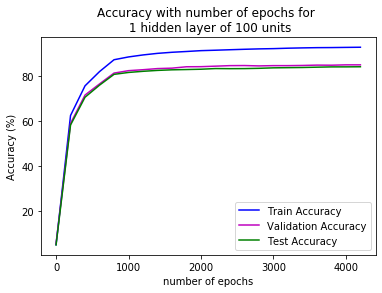

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of epochs for \n 1 hidden layer of 100 units")
ax.plot(plt_epoch, plt_train_acc, c='b', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, c='m',label='Validation Accuracy')
ax.plot(plt_epoch, plt_test_acc, c='g', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_epoch_100_valloss.png", dpi=1000, bbox_inches='tight')
plt.show()